In [1]:
import pandas as pd
import nltk
import json  
import sys  

import seaborn as sns  
import matplotlib.pyplot as plt  

from nltk.stem.snowball import EnglishStemmer
import plotly.express as px  
from sklearn.preprocessing import LabelEncoder  

# nltk.download('punkt')
# nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from tensorflow.keras.preprocessing.image import load_img  as load_img, img_to_array  as img_to_array
from tensorflow.keras.utils import to_categorical
from glob import glob


# TEXTE

## Recupérer et explorer les données

Je commence par lire mon fichier d'entrée

In [2]:
df = pd.read_csv("./../input/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
print("Shape is", df.shape)
df.head()

Shape is (1050, 15)


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

Je n'ai pas besoin de toute les colonnes, je conserve que ce qui m'interesse

In [4]:
df = df[["uniq_id","product_name","product_category_tree", "description"]]
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_name           1050 non-null   object
 2   product_category_tree  1050 non-null   object
 3   description            1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


In [6]:
df.nunique()

uniq_id                  1050
product_name             1050
product_category_tree     642
description              1050
dtype: int64

In [7]:
df.isna().sum()

uniq_id                  0
product_name             0
product_category_tree    0
description              0
dtype: int64

Je mets les categories sous forme de colonne hierachique

In [8]:
# Define a function to split and create the category columns dynamically  
def create_category_columns(row):
    json_categories = json.loads(row["product_category_tree"])
    if(len(json_categories) > 1):
        print("Categories array > 1, update the script to cover that.")
        sys.exit(1)  

    split_categories = json_categories[0].split(">>")
    
    for i, category in enumerate(split_categories):
        column_name = f"category_lvl_{i + 1}"  
        row[column_name] = category.strip().lower()
    return row

# Apply the funcion to all rows
df = df.assign(**df.apply(lambda row: create_category_columns(row), axis=1))  


In [9]:
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description   category_lvl_1  \
0  Key Features of Elegance Polyester Multicolor ...  home furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        baby care   
2  Key Features of Eurospa Cotton Terry Face Towe...        baby care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  home furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  home furnishing   

           category_lvl_2    category_lvl_3  \
0  curtains & accessories          curtains   
1        baby bath & skin  baby bath towels   
2        baby bath & skin  baby bath towels   
3               bed linen         bedsheets   
4               bed linen         bedsheets   

                                      category_lvl_4  \
0  elegance polyester multicolor abstract eyelet ...   
1                          sathiyas baby bath towels   
2                           eurospa baby bath towels   
3                    santosh royal fashion bedsheets   
4                             jaipur print bedsheets   

                                      category_lvl_5 category_lvl_6  \
0                                                NaN            NaN   
1  sathiyas cotton bath towel (3 bath towel, red,...            NaN   
2  eurospa cotton terry face towel set (20 piece ...            NaN   
3  santosh royal fashion cotton printed king size...            NaN   
4  jaipur print cotton floral king sized double b...            NaN   

  category_lvl_7  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [10]:
df.isna().sum()

uniq_id                    0
product_name               0
product_category_tree      0
description                0
category_lvl_1             0
category_lvl_2             0
category_lvl_3             3
category_lvl_4           371
category_lvl_5           645
category_lvl_6           923
category_lvl_7           993
dtype: int64

In [11]:
df["category_lvl_3"].fillna("undefined",inplace=True)
df["category_lvl_4"].fillna("undefined",inplace=True)
df["category_lvl_5"].fillna("undefined",inplace=True)
df["category_lvl_6"].fillna("undefined",inplace=True)
df["category_lvl_7"].fillna("undefined",inplace=True)
df.isna().sum()


uniq_id                  0
product_name             0
product_category_tree    0
description              0
category_lvl_1           0
category_lvl_2           0
category_lvl_3           0
category_lvl_4           0
category_lvl_5           0
category_lvl_6           0
category_lvl_7           0
dtype: int64

Je regarde la distribution de mes valeurs sur la première catégorie

In [12]:
df['category_lvl_1'].value_counts()

home furnishing               150
baby care                     150
watches                       150
home decor & festive needs    150
kitchen & dining              150
beauty and personal care      150
computers                     150
Name: category_lvl_1, dtype: int64

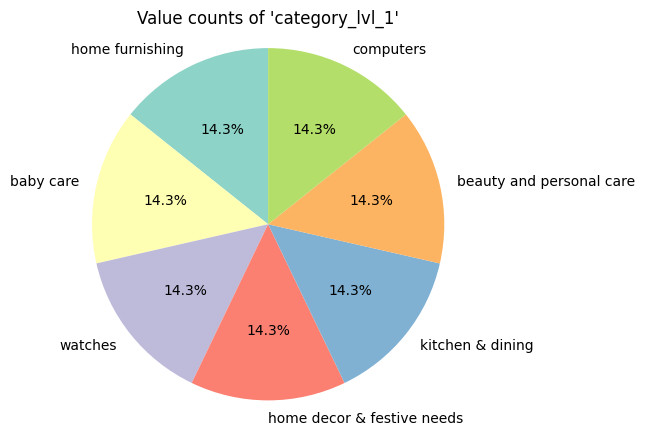

In [13]:
# Assuming 'df' is your DataFrame  
category_counts = df['category_lvl_1'].value_counts()  
  
# Set color palette from seaborn  
colors = sns.color_palette('Set3')  
  
# Create pie chart  
plt.figure(figsize=(5, 5))  
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)  
plt.axis('equal')  
plt.title("Value counts of 'category_lvl_1'")  
  
# Show the chart  
plt.show()  

La distribution est similaire pour chaque produits, j'affiche la 2e catégorie via le graphique sunburst

In [14]:
fig = px.sunburst(df, path=['category_lvl_1', 'category_lvl_2'])

fig.update_layout(  
    margin=dict(t=0, l=0, r=0, b=0),  
    width=500,  
    height=500,  
    title="Zoomable Sunburst Chart"  
)  

fig.show()

Je visualize avec Treemap pour observer la différence de rendu avec sunburst pour utiliser lors de la présentation

In [15]:
fig = px.treemap(df, path=['category_lvl_1', 'category_lvl_2', 'category_lvl_3'])  
  
fig.update_layout(  
    margin=dict(t=0, l=0, r=0, b=0),  
    width=800,  
    height=600,  
    title="Treemap Chart"  
)  
  
fig.show()

Je suis ok au niveau de la visualisation, ce qui m'interesse sera de classifier uniquement la catégorie lvl 1.  
Je vais donc mettre à jour mon dataframe

In [16]:
df = df[["uniq_id", "product_name", "description", "category_lvl_1"]]
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description   category_lvl_1  
0  Key Features of Elegance Polyester Multicolor ...  home furnishing  
1  Specifications of Sathiyas Cotton Bath Towel (...        baby care  
2  Key Features of Eurospa Cotton Terry Face Towe...        baby care  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  home furnishing  
4  Key Features of Jaipur Print Cotton Floral Kin...  home furnishing

J'effectue maintenant un label encoding sur mes categories

In [17]:
df = df.rename(columns={'category_lvl_1': 'cat'})
original_df = df.copy()

encoder = LabelEncoder()  
df["cat_e"] = encoder.fit_transform(df["cat"])  

In [18]:
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description              cat  cat_e  
0  Key Features of Elegance Polyester Multicolor ...  home furnishing      4  
1  Specifications of Sathiyas Cotton Bath Towel (...        baby care      0  
2  Key Features of Eurospa Cotton Terry Face Towe...        baby care      0  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  home furnishing      4  
4  Key Features of Jaipur Print Cotton Floral Kin...  home furnishing      4

Je vérifie si j'ai des doublons dans la description

In [19]:
idx = df.duplicated(subset="description", keep="first")
df.loc[idx,:].sort_values("description")

Empty DataFrame
Columns: [uniq_id, product_name, description, cat, cat_e]
Index: []

## Nettoyer la description

Je vais maintenant nettoyer la colonne description, ce qui consiste à analyser le nombre original de token (mots) et de les réduire au maximum tout en conservant la pertinence des mots. C'est à dire retirer les mots unique, retirer les mots qui ne sont pas anglais, ...

En nettoyant cette colonne, je vais pouvoir réduire le bruit et étudier au mieux la faisabilité de classification.

Je commence d'abord par créer mon corpus, le document qui va contenir toutes les description de tous les produits.

In [20]:

# HELPERS

import os, sys, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize

from nltk.corpus import words, stopwords
from nltk.tokenize import RegexpTokenizer

from wordcloud import WordCloud
from PIL import Image
from collections import Counter  

from pandarallel import pandarallel

# ---- 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE  
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans  
from umap import UMAP  
from sklearn.cluster import DBSCAN  
from sklearn.decomposition import TruncatedSVD  
from sklearn.decomposition import LatentDirichletAllocation  
from sklearn.metrics import accuracy_score  
from sklearn.metrics import confusion_matrix  
from gensim.models import Word2Vec  

# nltk.download("omw-1.4")
# nltk.download("wordnet")
# nltk.download("stopwords")
# nltk.download("words")

max_workers = os.cpu_count()  
print("Maximum number of workers:", max_workers)  

pandarallel.initialize(progress_bar=True, nb_workers=max_workers)

sns.set()

# Display the number of tokens and unique
def display_token_info(tokens):
    print(f"nb tokens {len(tokens)}, nb token uniques {len(set(tokens))}")
    print(tokens[:30])
    
english_stop_words = set(stopwords.words("english"))


def process_text_step_1(doc):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    
    return:
    -------------------
    
    a list of tokens
    """
    
    # Reduce to lowercase
    doc = doc.lower().strip()
    
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    # Remove stop words
    # clean_tokens_list = [w for w in raw_tokens_list if w not in english_stop_words]
    
    return raw_tokens_list

def process_text_step_2(doc, stopwords):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_1(doc)
    
    # Remove stop words
    processed_tokens = [w for w in processed_tokens if w not in stopwords]
    
    return processed_tokens

def process_text_step_3(doc, stopwords):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_2(doc, stopwords)
    
    processed_tokens = [w for w in processed_tokens if w.isalpha()]
    
    return processed_tokens

def process_text_step_4(doc, 
                        stopwords, 
                        delete_words
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_3(doc, stopwords)
    processed_tokens = [w for w in processed_tokens if w not in delete_words]
    
    return processed_tokens

def process_text_step_5(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_4(doc, stopwords, delete_words)
    processed_tokens = [w for w in processed_tokens if len(w) >= min_word_length]

    return processed_tokens

def process_text_step_6(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length,
                        use_lemm,
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    use_lemm: bool : define if it uses lemmatizer, if false, it will defined stemmer
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_5(doc, stopwords, delete_words, min_word_length)

    if use_lemm:
         trans = WordNetLemmatizer()
         processed_tokens = [trans.lemmatize(i) for i in processed_tokens]
    else:
        trans = PorterStemmer()
        processed_tokens = [trans.stem(i) for i in processed_tokens]

    # Could improve this by reordering step, not needed for now
    # Once again, I remove all tokens >= min_word_length
    processed_tokens = [w for w in processed_tokens if len(w) >= min_word_length]
    # Once again, I remove all delete_words
    processed_tokens = [w for w in processed_tokens if w not in delete_words]

    return processed_tokens

def final_process(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length,
                        use_lemm,
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    use_lemm: bool : define if it uses lemmatizer, if false, it will defined stemmer
    
    return:
    -------------------
    
    a str of joined token
    """
    processed_tokens = process_text_step_6(doc, stopwords, delete_words, min_word_length, use_lemm)

    if use_lemm:
         trans = WordNetLemmatizer()
         processed_tokens = [trans.lemmatize(i) for i in processed_tokens]
    else:
        trans = PorterStemmer()
        processed_tokens = [trans.stem(i) for i in processed_tokens]

    # Could improve this by reordering step, not needed for now
    # Once again, I remove all tokens >= min_word_length
    processed_tokens = [w for w in processed_tokens if len(w) >= min_word_length]
    # Once again, I remove all delete_words
    processed_tokens = [w for w in processed_tokens if w not in delete_words]

    return " ".join(processed_tokens)

def process_text_step_7_deprecated(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length,
                        use_lemm,
                        allow_words,
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    use_lemm: bool : define if it uses lemmatizer, if false, it will defined stemmer
    include_words: list : a list of words to allow to keep
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_6(doc, stopwords, delete_words, min_word_length, use_lemm)
    processed_tokens = [i for i in processed_tokens if i in allow_words]
    return processed_tokens


Maximum number of workers: 8
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [21]:
raw_corpus = " ".join(df["description"].values)
raw_corpus

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

J'observe le nombre de charactères

In [22]:
len(raw_corpus)

498561

**Première analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule

In [23]:
tokens = process_text_step_1(raw_corpus)
display_token_info(tokens)

nb tokens 81563, nb token uniques 6085
['key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'in', 'height', 'pack', 'of', '2', 'price', 'rs', '899', 'this']


J'ai donc un nombre de token initial de 81,219 token et 6,284 unique.  
Je vais tenter de réduire se nombre au maximum par itération.  

Je souhaite retirer tous les mots qui sont considérés comme stopwords en Anglais, des mots qui ne seront pas utile à définir une catégorie (le, la, les, ...)

**Deuxième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.

In [24]:
tokens = process_text_step_2(raw_corpus, english_stop_words)
display_token_info(tokens)

nb tokens 61786, nb token uniques 5966
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2', 'price', 'rs', '899', 'curtain', 'enhances', 'look', 'interiors']


Déjà ~20k tokens retiré, c'est que le début

Maintenant je souhaite retirer toutes les valeurs qui sont des nombres, je ne pense pas que les valeurs numériques me permettent de mieux distinguer une catégorie.

**Troisième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.
- Je supprime tous les mots numériques

In [25]:
tokens = process_text_step_3(raw_corpus, english_stop_words)
display_token_info(tokens)

nb tokens 55622, nb token uniques 4897
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'rs', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high']


6k tokens de réduit donc 1k token uniques.  
Maintenant, je pense que tous les mots présent uniquement une seul fois dans le corpus ne sont pas utiles pour déterminer une catégorie, je vais donc les supprimer.

In [26]:
pd.Series(tokens).value_counts()

rs          911
products    631
free        618
buy         581
delivery    567
           ... 
playing       1
husband       1
merry         1
stroll        1
png           1
Length: 4897, dtype: int64

In [27]:
all_tokens = pd.Series(tokens).value_counts()
tokens_one_occurence = all_tokens[all_tokens==1]
tokens_one_occurence = list(tokens_one_occurence.index)

print("len",len(tokens_one_occurence))
tokens_one_occurence[:5]

len 1436


['factor', 'recently', 'anything', 'enable', 'ribs']

**Quatrième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.
- Je supprime tous les mots numériques
- Je supprime tous les mots qui sont présent qu'une seul fois


In [28]:
tokens = process_text_step_4(raw_corpus, english_stop_words, delete_words=tokens_one_occurence)
display_token_info(tokens)

nb tokens 54186, nb token uniques 3461
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'rs', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high']


~1500 tokens unique retiré. Je continue.  
Je vais observer tous les mots qui ont moins de 3 caractères, je ne suis pas sur que ces mots définissent une catégorie facilement.

Rien d'interessant a vue d'oeil.  
Je les supprime.

**Cinquième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.
- Je supprime tous les mots numériques
- Je supprime tous les mots qui sont présent qu'une seul fois
- Je supprime tous les mots qui font moins de 3 caractères


In [29]:
tokens = process_text_step_5(raw_corpus, english_stop_words, delete_words=tokens_one_occurence, min_word_length=3)
display_token_info(tokens)

nb tokens 51562, nb token uniques 3374
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester']


Pas beaucoup de tokens retirés, c'est mieux que rien.  
Maintenant le plus intéressant, stemmer ou lemmatizer ?

- Stemmer: réduit les mots à leur racine (supprime les affixes) (rapide et ne tient pas en compte le contexte)
- Lemmatizer: Normalize les mots depuis un dictionnaire (lent et tient en compte le sens des mots)

Ici, je souhaite classifier une catégorie, je ne pense pas que le sens des mots soit important comparé à une analyse de positivité d'un text.  
Je pense utiliser celui qui me supprimera le plus de token. Je pourrais aussi retenter mon approche plus bas avec l'autre méthode.

**Sixième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.
- Je supprime tous les mots numériques
- Je supprime tous les mots qui sont présent qu'une seul fois
- Je supprime tous les mots qui font moins de 3 caractères
- J'effectue un Stemmer ou Lemmatizer


In [30]:
tokens = process_text_step_6(raw_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=True)
display_token_info(tokens)

nb tokens 51155, nb token uniques 3067
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester']


In [31]:
tokens = process_text_step_6(raw_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=False)
display_token_info(tokens)

nb tokens 50887, nb token uniques 2703
['key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhanc', 'look', 'interior', 'curtain', 'made', 'high', 'qualiti', 'polyest']


Plus rapide et moins de token par stemmer, je vais donc utiliser cette méthode par la suite.  
Ça commence à être pas trop mal. 

Je vais maintenant tester de retirer tous les mots qui ne sont pas dans la langue anglaise.

In [32]:
eng_words = [i.lower() for i in words.words()]
len(set(eng_words))

234377

In [33]:
tokens = process_text_step_7_deprecated(raw_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=False,
                             allow_words=eng_words)
display_token_info(tokens)

nb tokens 34054, nb token uniques 1493
['key', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'look', 'interior', 'curtain', 'made', 'high', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room']


Je suis pas fan, j'ai peur de retirer trop de mots. Je perds "featur", même si je modifie le step 7 pour ne pas faire de stemmer, je perds également le mot "feature".  
Je n'ai pas confiance en cette méthode, je ne l'utiliserai pas.

C'est déjà pas mal, je vais observer les mots les plus courant pour chaque catégorie puis vérifier si il y a des doublons entre toute les catégories et supprimer ce que je trouve inutile.

In [34]:
df.columns

Index(['uniq_id', 'product_name', 'description', 'cat', 'cat_e'], dtype='object')

home furnishing has 57118 characters for 5925 words


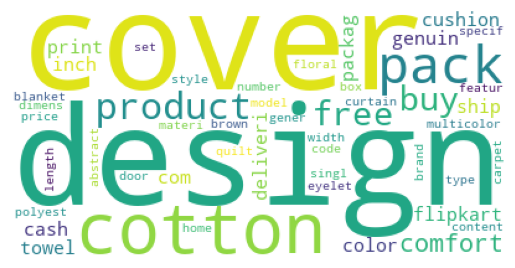

baby care has 72541 characters for 8191 words


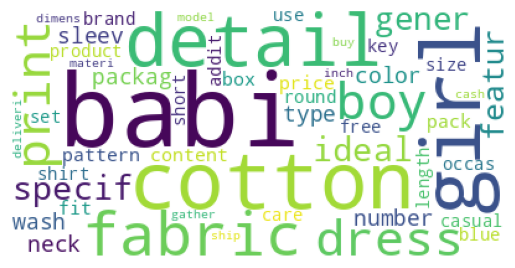

watches has 49083 characters for 5062 words


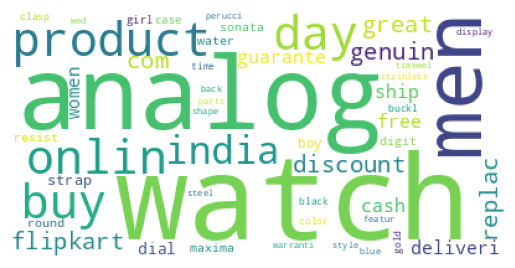

home decor & festive needs has 84704 characters for 8226 words


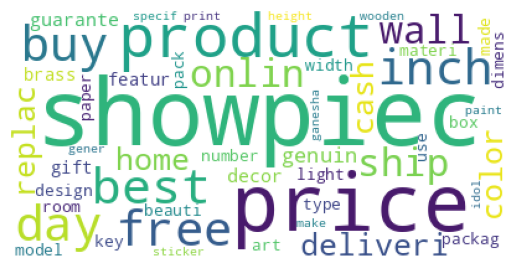

kitchen & dining has 95162 characters for 9289 words


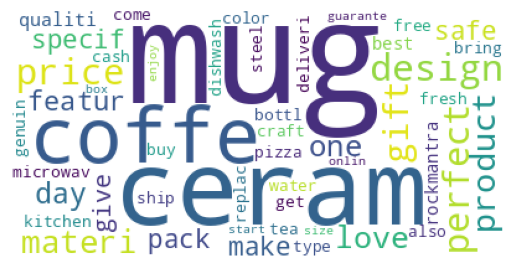

beauty and personal care has 56618 characters for 5856 words


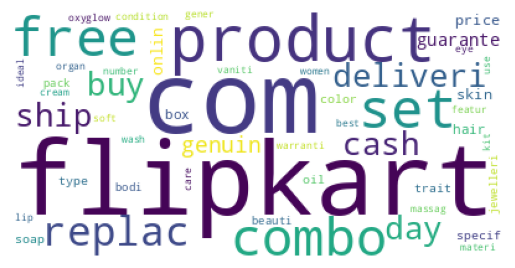

computers has 83329 characters for 8338 words


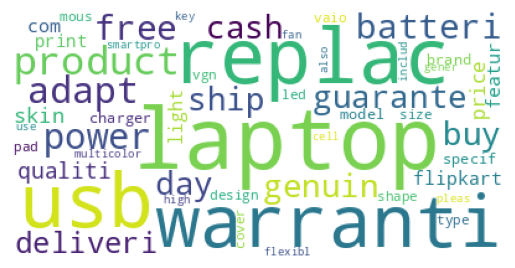

In [35]:
tokens_per_cat={}
for idx, cat in enumerate(df["cat"].unique()):
    df_cat = df[df['cat'] == cat]
    cat_corpus = " ".join(df_cat["description"])
    
    tokens_per_cat[cat] = process_text_step_6(cat_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=False)
    
    print(f"{cat} has {len(cat_corpus)} characters for {len(tokens_per_cat[cat])} words")
    word_frequencies = Counter(tokens_per_cat[cat])  

    wordcloud = WordCloud(background_color="white",
                      stopwords=[],
                      max_words=50).generate_from_frequencies(frequencies=word_frequencies)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    

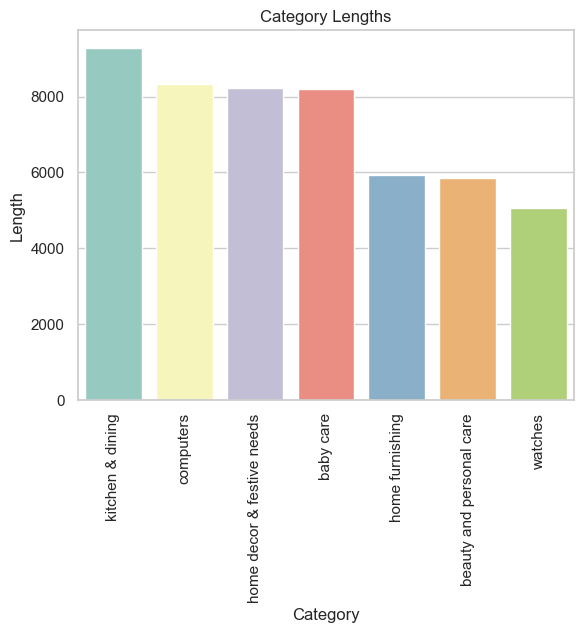

In [36]:
category_keys = list(tokens_per_cat.keys())  
  
lengths = [len(tokens_per_cat[key]) for key in category_keys]  
df_cat = pd.DataFrame({"Category": category_keys, "Length": lengths})  
df_cat = df_cat.sort_values(by="Length", ascending=False)  
  
color_palette = sns.color_palette("Set3")  
sns.set(style="whitegrid")  
sns.barplot(x="Category", y="Length", data=df_cat, palette=color_palette)  
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary  
plt.xlabel("Category")  
plt.ylabel("Length")  
plt.title("Category Lengths")  
plt.show()  

In [37]:
categories = list(tokens_per_cat.keys())  
duplicated_values = []  
  
for value in pd.Series(tokens_per_cat[categories[0]]).value_counts().index:  
    if all(value in pd.Series(tokens_per_cat[cat]).values for cat in categories[1:]):  
        duplicated_values.append(value)
  
print(len(duplicated_values))  
print(duplicated_values)

79
['cover', 'design', 'pack', 'product', 'buy', 'free', 'comfort', 'cash', 'ship', 'deliveri', 'flipkart', 'genuin', 'color', 'packag', 'materi', 'price', 'featur', 'brand', 'width', 'specif', 'dimens', 'box', 'gener', 'number', 'set', 'content', 'style', 'type', 'height', 'qualiti', 'key', 'made', 'green', 'blue', 'look', 'beauti', 'weight', 'use', 'black', 'size', 'colour', 'long', 'high', 'white', 'shape', 'pink', 'back', 'come', 'bodi', 'day', 'add', 'suitabl', 'ideal', 'place', 'durabl', 'india', 'red', 'make', 'well', 'life', 'new', 'world', 'water', 'one', 'great', 'rang', 'light', 'sure', 'vari', 'manufactur', 'replac', 'multi', 'need', 'may', 'get', 'like', 'wide', 'touch', 'finish']


J'ai 79 mots en doublons dans toutes les catégories. Ça me rajoutera du bruit, je préfère les retirer.  
Pour rappel, le résultat précédent que je conserve est: `nb tokens 51097, nb token uniques 3123`

In [38]:
words_deleted_manually = []
# words_deleted_manually = ["com","guarante","best","onlin","warranti","print"]
new_delete_words = list(set(tokens_one_occurence + duplicated_values + words_deleted_manually))
tokens = process_text_step_6(raw_corpus, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3,
                             use_lemm=True)
display_token_info(tokens)

nb tokens 40141, nb token uniques 3005
['feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'curtain', 'enhances', 'interior', 'curtain', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'stitch', 'metal', 'ring', 'room']


Beaucoup de mots retirés mais je suis confiant que c'est utile.

In [39]:
tokens_per_cat[cat]

['key',
 'featur',
 'link',
 'app',
 'android',
 'specif',
 'link',
 'white',
 'speed',
 'wireless',
 'speed',
 'mbp',
 'dsl',
 'modem',
 'speed',
 'mbp',
 'gener',
 'brand',
 'link',
 'box',
 'extend',
 'plug',
 'model',
 'type',
 'rang',
 'color',
 'white',
 'warranti',
 'cover',
 'warranti',
 'damag',
 'warranti',
 'summari',
 'servic',
 'type',
 'damag',
 'cover',
 'warranti',
 'damag',
 'repair',
 'dimens',
 'weight',
 'connect',
 'number',
 'antenna',
 'number',
 'usb',
 'antenna',
 'support',
 'standard',
 'ieee',
 'ieee',
 'oper',
 'condit',
 'oper',
 'oper',
 'non',
 'condens',
 'storag',
 'non',
 'condens',
 'temperatur',
 'oper',
 'storag',
 'degre',
 'addit',
 'featur',
 'certif',
 'key',
 'featur',
 'roq',
 'slim',
 'multimedia',
 'flexibl',
 'wire',
 'usb',
 'flexibl',
 'keyboard',
 'size',
 'handheld',
 'roq',
 'slim',
 'multimedia',
 'flexibl',
 'wire',
 'usb',
 'flexibl',
 'keyboard',
 'white',
 'price',
 'work',
 'environ',
 'fit',
 'easili',
 'backpack',
 'keyboard',

home furnishing has 57118 characters for 3559 words


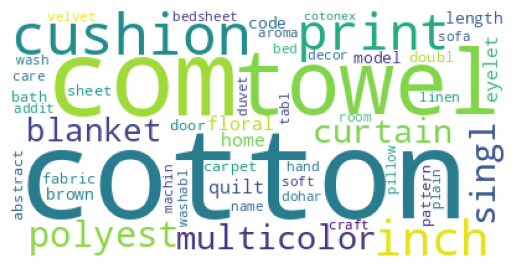

baby care has 72541 characters for 5953 words


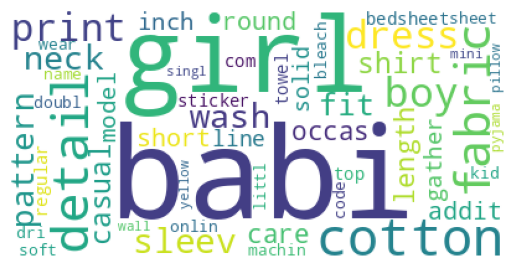

watches has 49083 characters for 3026 words


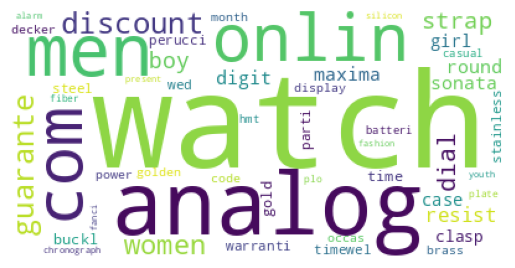

home decor & festive needs has 84704 characters for 5743 words


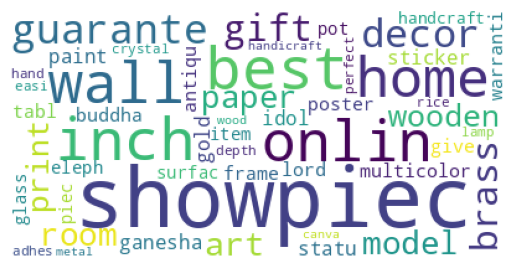

kitchen & dining has 95162 characters for 6578 words


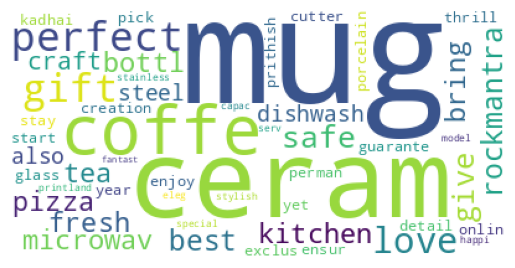

beauty and personal care has 56618 characters for 3729 words


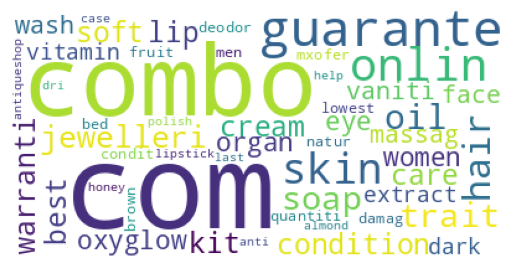

computers has 83329 characters for 5851 words


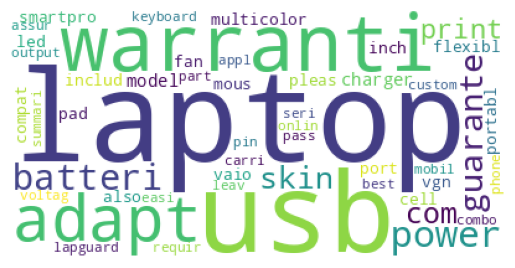

In [40]:
tokens_per_cat={}
for idx, cat in enumerate(df["cat"].unique()):
    df_cat = df[df['cat'] == cat]
    cat_corpus = " ".join(df_cat["description"])
    
    tokens_per_cat[cat] = process_text_step_6(cat_corpus, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3,
                             use_lemm=False)
    
    print(f"{cat} has {len(cat_corpus)} characters for {len(tokens_per_cat[cat])} words")
    word_frequencies = Counter(tokens_per_cat[cat])  

    wordcloud = WordCloud(background_color="white",
                      stopwords=[],
                      max_words=50).generate_from_frequencies(frequencies=word_frequencies)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Je suis satisfait de ce nettoyage.

Pour rappel, step initial: `nb tokens 81219, nb token uniques 6284`  
maintenant: `nb tokens 39942, nb token uniques 3030`

Réduction de plus de 50%.
Je vais donc lancer cette transormation sur toutes les lignes de mon dataframe et rajouter une colonne "description_clean"

In [41]:
df_clean_lemm = df.copy()
df_clean_stemm = df.copy()

df_clean_stemm["clean_desc"] = df_clean_stemm["description"].parallel_apply(lambda x: final_process(x, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3,
                             use_lemm=False))

df_clean_lemm["clean_desc"] = df_clean_lemm["description"].parallel_apply(lambda x: final_process(x, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3,
                             use_lemm=False))



In [42]:
### BONUS FOR TESTING
df_clean = df.copy()
df_clean["clean_desc_step1"] = df_clean_stemm["description"].parallel_apply(lambda x: " ".join(process_text_step_1(x)))

df_clean["clean_desc_step2"] = df_clean_stemm["description"].parallel_apply(lambda x: " ".join(process_text_step_2(x, 
                             english_stop_words)))

df_clean["clean_desc_step3"] = df_clean_stemm["description"].parallel_apply(lambda x: " ".join(process_text_step_3(x, 
                             english_stop_words)))

df_clean["clean_desc_step4"] = df_clean_stemm["description"].parallel_apply(lambda x: " ".join(process_text_step_4(x, 
                             english_stop_words, 
                             delete_words=new_delete_words)))

df_clean["clean_desc_step5"] = df_clean_stemm["description"].parallel_apply(lambda x: " ".join(process_text_step_5(x, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3)))

J'affiche la colonne description orginal et celle nettoyé pour les comparés

In [43]:
pd.set_option('display.max_colwidth', -1)  
df_clean_stemm[["description","clean_desc"]].head(3)

/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_3321/4196092188.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Name SHUVAM20PCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAM20PCFTSETASSORTED Size small Color Assorted Dimensio

In [44]:
#df[df["clean_desc"].isna()]["description"]
df_clean_stemm[df_clean_stemm["clean_desc"] == ""]
# df = df.drop(df[df["clean_desc"] == ""].index)

Empty DataFrame
Columns: [uniq_id, product_name, description, cat, cat_e, clean_desc]
Index: []

Je sauvegarde mon dataframe dans un csv.

In [45]:
df_clean_stemm.to_csv("./../input/df_cleaned_stemm.csv", index=False)
df_clean_lemm.to_csv("./../input/df_cleaned_lemm.csv", index=False)

À noter, je n'ai pas utiliser de bi-grams ou tri-grams car dans une première réflexion, je ne pense pas que c'est utile pour classifier des catégories.

Néamoins, pour valider cette approche, je le ferais tout de même par la suite pour observer la différence de précision.

In [46]:
for idx, item in df_clean_stemm.iterrows():
    desc = item["clean_desc"]
    words = desc.split(" ")  
    
    df_clean_stemm.at[idx, 'word_count_clean'] = len(words)  
    df_clean_stemm.at[idx, 'unique_word_count_clean'] = len(set(words))
    
for idx, item in df_clean_lemm.iterrows():
    desc = item["clean_desc"]
    words = desc.split(" ")  
    
    df_clean_lemm.at[idx, 'word_count_clean'] = len(words)  
    df_clean_lemm.at[idx, 'unique_word_count_clean'] = len(set(words)) 

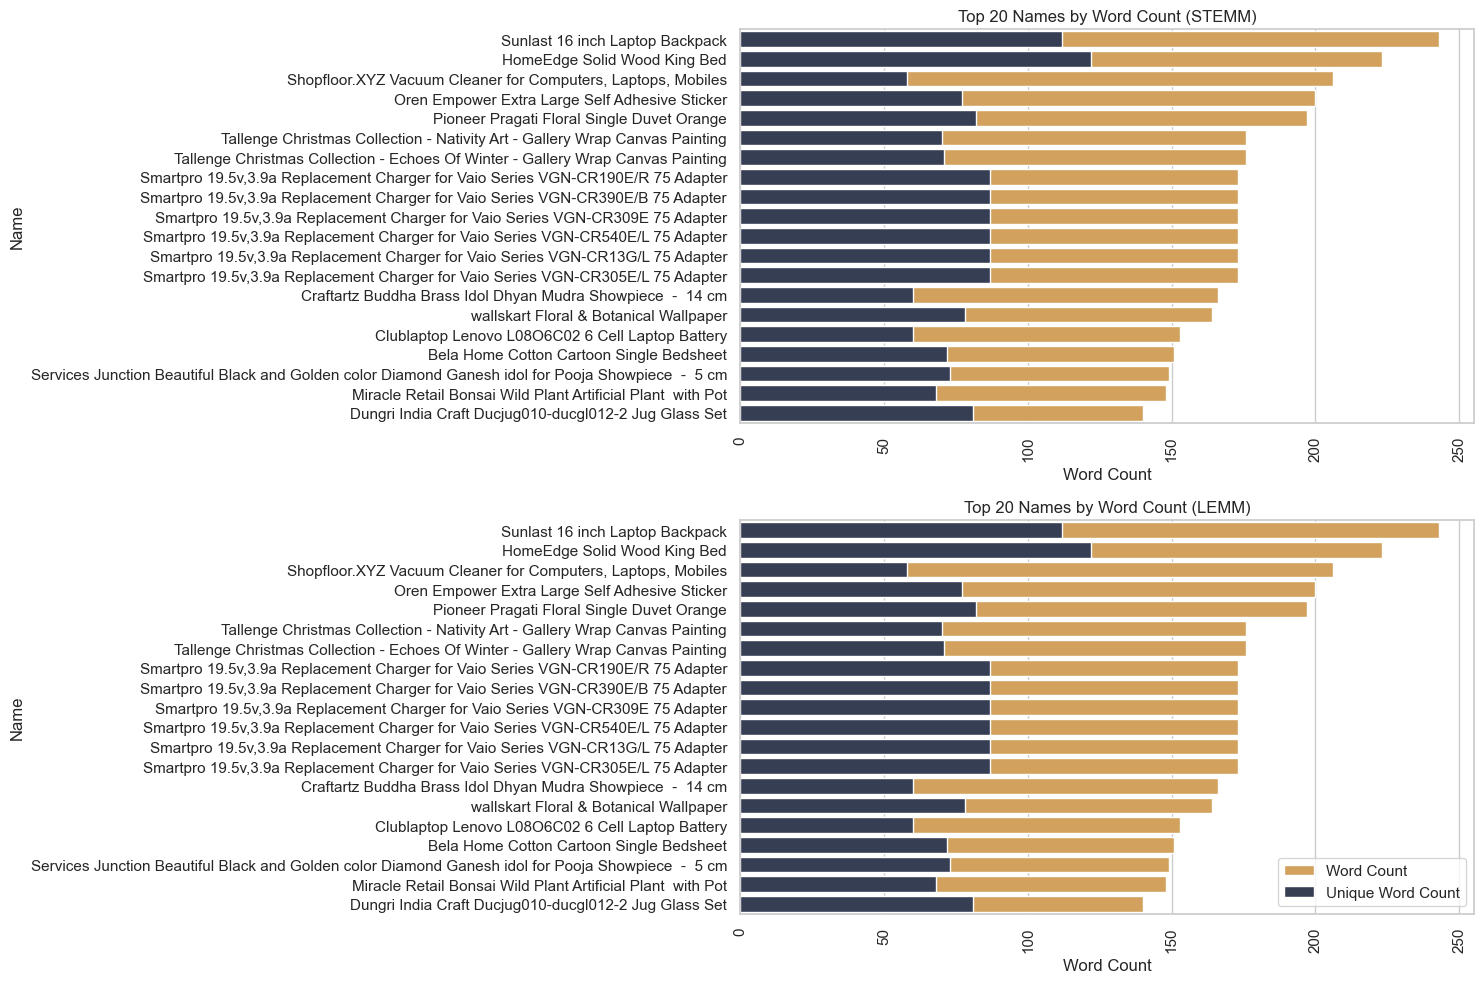

In [47]:
sorted_df_clean = df_clean_stemm.sort_values("word_count_clean", ascending=False)    
top_names = sorted_df_clean["product_name"].head(20)  
  
top_word_counts = sorted_df_clean["word_count_clean"].head(20)  
top_unique_counts = sorted_df_clean["unique_word_count_clean"].head(20)  

plt.figure(figsize=(15, 10))  
plt.subplot(2, 1, 1)

# Create a horizontal barplot using seaborn    
sns.barplot(y=top_names, x=top_word_counts, orient="h",  color="#e7a44a", label="Word Count")    
sns.barplot(y=top_names, x=top_unique_counts, orient="h",  color="#313c59", label="Unique Word Count")    

# Set the title and axes labels    
plt.title("Top 20 Names by Word Count (STEMM)")    
plt.xlabel("Word Count")    
plt.ylabel("Name")    

# Rotate x-axis labels for better readability    
plt.xticks(rotation=90)
    
plt.subplot(2, 1, 2)
sorted_df_clean = df_clean_lemm.sort_values("word_count_clean", ascending=False)    
top_names = sorted_df_clean["product_name"].head(20)  
  
top_word_counts = sorted_df_clean["word_count_clean"].head(20)  
top_unique_counts = sorted_df_clean["unique_word_count_clean"].head(20)  

# Create a horizontal barplot using seaborn    
sns.barplot(y=top_names, x=top_word_counts, orient="h",  color="#e7a44a", label="Word Count")    
sns.barplot(y=top_names, x=top_unique_counts, orient="h",  color="#313c59", label="Unique Word Count")    

# Set the title and axes labels    
plt.title("Top 20 Names by Word Count (LEMM)")    
plt.xlabel("Word Count")    
plt.ylabel("Name")    

# Rotate x-axis labels for better readability    
plt.xticks(rotation=90)

# Display the plot 
plt.legend()
plt.tight_layout()  
plt.show()  


## Classification text non supervisé & supervisé

Étapes:
- **Non supervisé**
  - Extraction des features
  - Réduction en 2 dimensions
  - Kmeans
  - Visualisation Graphique
  - Score

- **Supervisé**
  - Extraction des features
  - Réduction en 2 dimensions
  - Classification avec apprentissage
  - Visualisation Graphique
  - Score


In [48]:
from transformers import BertTokenizer, BertModel  
import tensorflow as tf  
import tensorflow_hub as hub  
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  

def plot_confusion_matrix(y_true, y_pred, labels, title):  
    """  
    Plots the confusion matrix for clustering results.  
    """  
    cm = confusion_matrix(y_true, y_pred)  
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)  
    plt.xlabel('Predicted')  
    plt.ylabel('True')  
    plt.title(f"Confusion matrix {title}")
  
# Plot the confusion matrix  
# labels = np.unique(test_df['orginal_cat'])  # Unique labels in target labels  
# plot_confusion_matrix(test_df['orginal_cat'], test_df['predicted_cat'], labels)  


def modify_labels(y_true, y_pred):  
    """  
    Modifies the predicted values based on the confusion matrix.  
    """  
    cm = confusion_matrix(y_true, y_pred)  
    n_classes = len(np.unique(y_true))  
    modified_pred = np.copy(y_pred)
    
    mapping = {}
    for true_label in range(n_classes): 
        max_count = -1  
        for pred_label in range(n_classes):
            if cm[true_label, pred_label] > max_count and pred_label not in mapping.values():  
                max_count = cm[true_label, pred_label]
                mapping[true_label] = pred_label
        
        # print(mapping)
        # # print(mapping)
        # print(f"Replace y_pred {mapping[true_label]} by {true_label}, because {max_count}")
        # print()
    for true_label, pred_label in mapping.items():  
         modified_pred[y_pred == pred_label] = true_label
        
    return modified_pred
  
# # Modify the predicted values based on the confusion matrix  
# test_df['predicted_cat_adjusted'] = modify_labels(test_df['orginal_cat'], test_df['predicted_cat'])
# plot_confusion_matrix(test_df['orginal_cat'], test_df['predicted_cat_adjusted'], labels)  

def check_performance(df, 
                      reduction_name, 
                      reduction_method,
                      
                      clustering_name,
                      clustering_method,
                      
                      original_df,
                      draw_graph=False):
    
    # Apply a dimensional reduction  
    reduced_data = reduction_method.fit_transform(df)  

    # Determine new clusters  
    # kmeans = KMeans(n_clusters=7, n_init=10) # Change the number of clusters based on your data  
    clusters = clustering_method.fit_predict(reduced_data)

    # clusters_adjusted = clusters
    clusters_adjusted = modify_labels(original_df['cat_e'], clusters)
    # Print the ARI score  
    ari_score = adjusted_rand_score(original_df['cat_e'], clusters)
    accuracy = accuracy_score(original_df['cat_e'], clusters)  
    
    accuracy_adjusted = accuracy_score(original_df['cat_e'], clusters_adjusted)  
    
    if(draw_graph):
        print(f"ARI Score ({clustering_name} - {reduction_name}) : %.2f" % ari_score)  
        print(f"ACCURACY ({clustering_name} - {reduction_name}) : %.2f" % accuracy)  
        print(f"ACCURACY Adjusted ({clustering_name} - {reduction_name}) : %.2f" % accuracy_adjusted)  
        
        # Plot on the left the datapoints with existing categories  
        plt.figure(figsize=(12, 3))  
        plt.subplot(1, 2, 1)  
        sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=original_df['cat'], palette='Set1')  
        plt.title(f"Real Categories {clustering_name} - {reduction_name}")  
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  
        
        # Plot on the right the datapoints with determined categories  
        plt.subplot(1, 2, 2)  
        sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=clusters, palette='Set1')  
        plt.title(f"Predicted Categories {clustering_name} - {reduction_name}")  
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  
    
        plt.tight_layout()  
        plt.show()
        
        plt.figure(figsize=(12, 3))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(original_df['cat_e'], clusters, np.unique(original_df['cat_e']), "Predicted")
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(original_df['cat_e'], clusters_adjusted, np.unique(original_df['cat_e']), "Predicted and adjusted")
        plt.tight_layout()  
        plt.show()
    
    
    return {"label": f"{reduction_name}", "ari_score": ari_score,"accuracy": accuracy_adjusted, "clusters": clusters}

In [49]:
# kmeans = KMeans(n_clusters=7, n_init=10, init='k-means++', max_iter=300, random_state=23)
# tsne = PCA(n_components=2)
# test_res = check_performance(tfidf_df, 
#                             "tsne", 
#                             tsne, 
#                             "kmeans", 
#                             kmeans, 
#                             df,
#                             draw_graph=True)
# kmeans = KMeans(n_clusters=7, n_init=10, init='k-means++', max_iter=300, random_state=23)
# tsne = TSNE(n_components=2, random_state=23)
# test_res = check_performance(tfidf_df, 
#                             "tsne", 
#                             tsne, 
#                             "kmeans", 
#                             kmeans, 
#                             df,
#                             draw_graph=True)

In [50]:
clusterings = [
    {"name": "KMEANS", "model": KMeans(n_clusters=7, n_init=10, init='k-means++', max_iter=300, random_state=42)},
    # {"name": "DBSCAN", "model": DBSCAN(eps=0.5, min_samples=5)  }
]

dimension_reduction = [
    {"name": "PCA", "model": PCA(n_components=2)},
    {"name": "t-SNE", "model": TSNE(n_components=2, perplexity=40, random_state=42)  },
    {"name": "UMAP", "model": UMAP(n_components=2) },
    {"name": "SVD", "model": TruncatedSVD(n_components=2) },
]


def check_one_df(dataFrame, draw_graph=False):
    
    df_scores = pd.DataFrame(columns=["label", "ari", "accuracy"])  

    for idx, dim_reduc in enumerate(dimension_reduction):
        for idx2, clustering in enumerate(clusterings):
            res = check_performance(dataFrame, 
                            dim_reduc["name"], 
                            dim_reduc["model"], 
                            clustering["name"], 
                            clustering["model"], 
                            df,
                            draw_graph)
            row = pd.DataFrame({"label": res["label"], "ari": res["ari_score"], "accuracy": res["accuracy"]}, index=[0])
            df_scores = pd.concat([df_scores, row], ignore_index=True)
            
    return df_scores

In [51]:
# CountVectorizer
count_vectorizer = CountVectorizer()  
bow_matrix = count_vectorizer.fit_transform(df_clean_stemm['clean_desc'])  
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())   
bow_df_scores = check_one_df(bow_df,False)

In [52]:
df_clean_lemm['clean_desc']

0       eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain curtain enhanc interior curtain polyest fabric eyelet stitch metal ring room environ curtain ant wrinkl anti shrinkag eleg give home bright appeal attent contemporari eyelet curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole draw even creat special moment given sooth print bring home eleg curtain room right amount sunlight eleg polyest multicolor abstract eyelet door curtain eleg door eyelet model name abstract polyest door curtain model multicolor length curtain polyest                                                                                                                                                                                                                                                                                                                                                            

ARI Score (KMEANS - PCA) : 0.17
ACCURACY (KMEANS - PCA) : 0.13
ACCURACY Adjusted (KMEANS - PCA) : 0.19


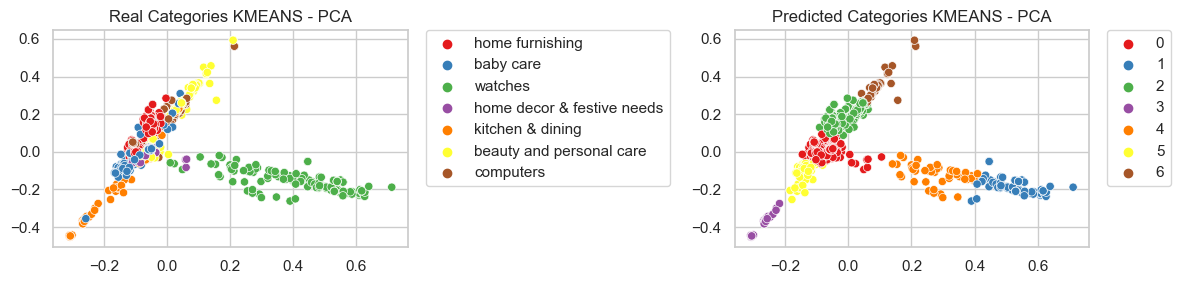

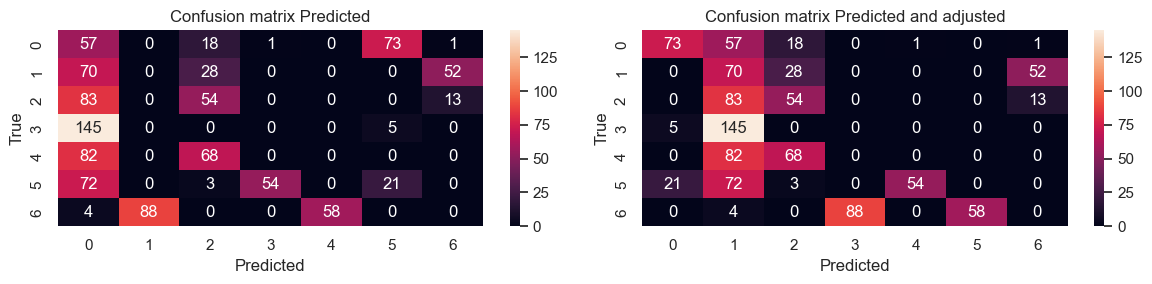

ARI Score (KMEANS - t-SNE) : 0.48
ACCURACY (KMEANS - t-SNE) : 0.21
ACCURACY Adjusted (KMEANS - t-SNE) : 0.69


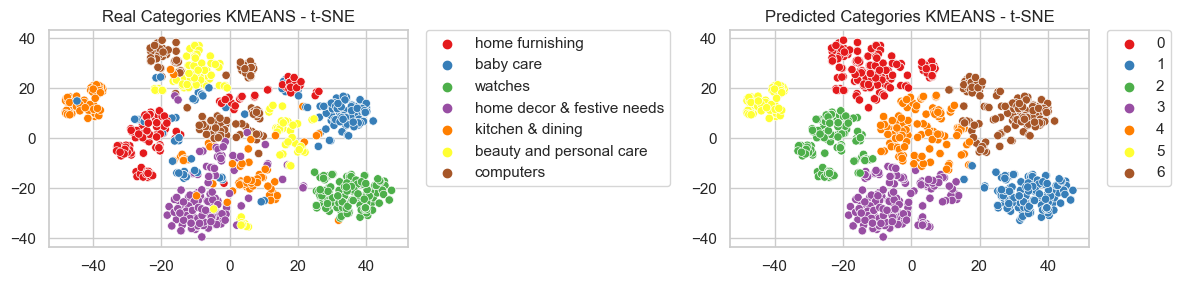

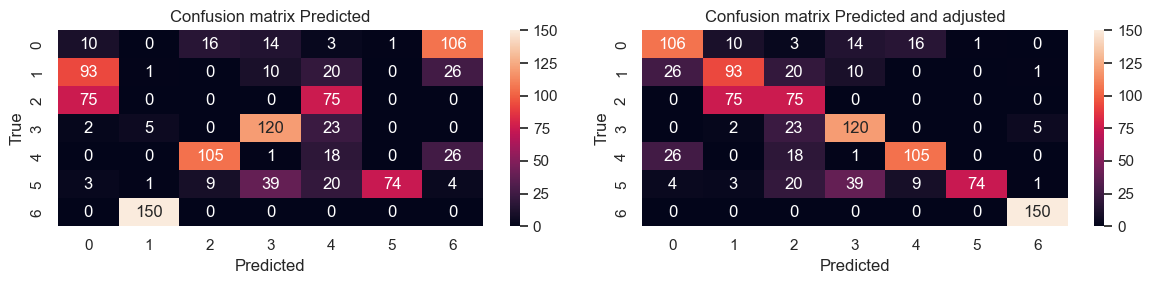

ARI Score (KMEANS - UMAP) : 0.51
ACCURACY (KMEANS - UMAP) : 0.17
ACCURACY Adjusted (KMEANS - UMAP) : 0.26


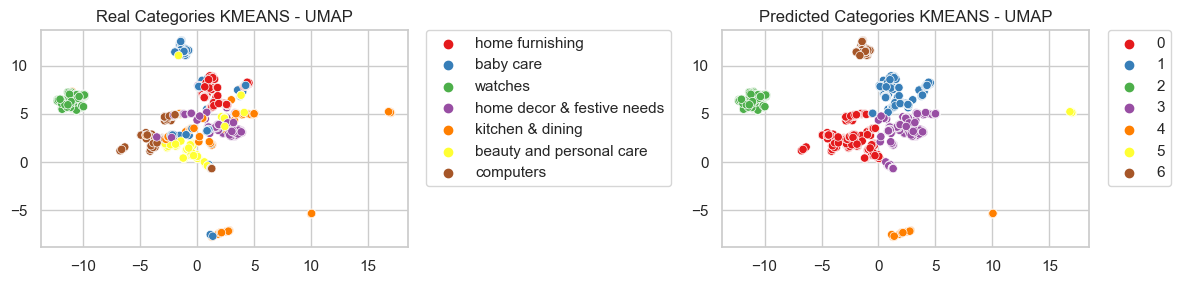

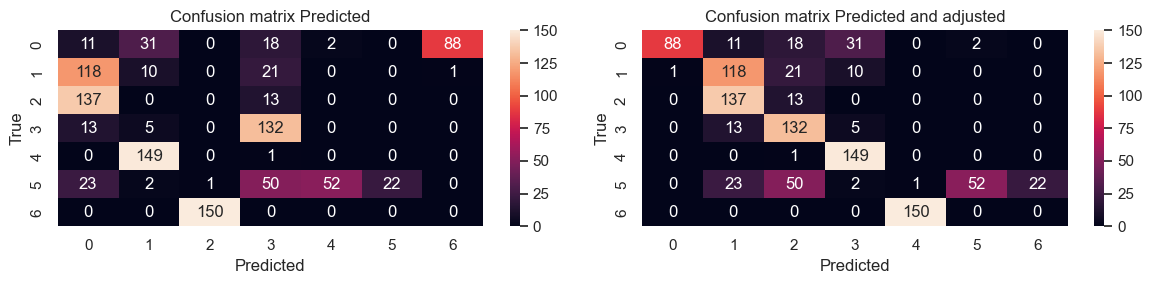

ARI Score (KMEANS - SVD) : 0.14
ACCURACY (KMEANS - SVD) : 0.12
ACCURACY Adjusted (KMEANS - SVD) : 0.22


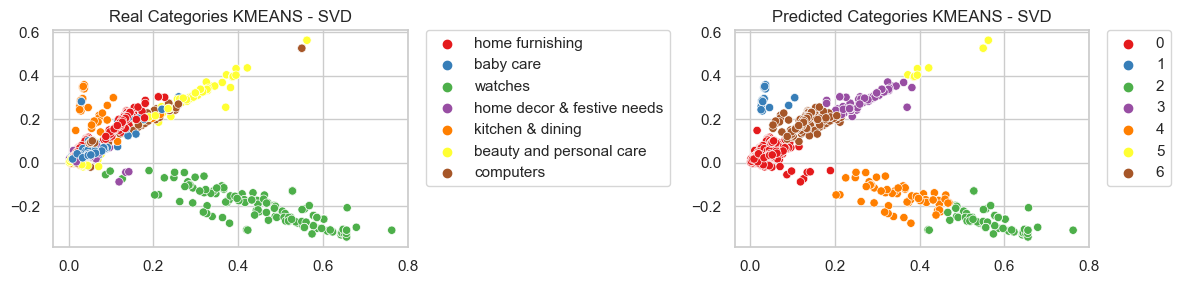

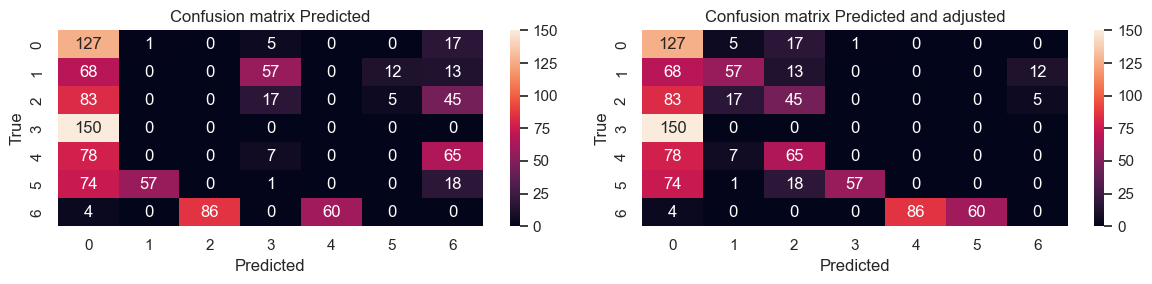

In [53]:
# TF-IDF method  
tfidf_vectorizer = TfidfVectorizer()  
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean_lemm['clean_desc'])  
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df_scores = check_one_df(tfidf_df, True)

In [54]:

# Will be redefined later on
def check_one_df_supervised():
    return np.nan

def get_score_bert(texts, supervised=False):  
    # Load pre-trained BERT model & tokenizer  
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  
    model = BertModel.from_pretrained('bert-base-uncased')  
      
    bert_embeddings = []  
      
    for desc in texts:  
        # Encode the descriptions using BERT tokenizer  
        inputs = tokenizer(desc, padding=True, truncation=True, return_tensors="pt", max_length=512)  
        # Get the output from BERT model  
        outputs = model(**inputs)  
        # Use the mean of the last hidden states as the document representation  
        embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()  
        bert_embeddings.append(embeddings[0])  
          
    bert_df = pd.DataFrame(bert_embeddings)
    
    if(supervised):
        return check_one_df_supervised(bert_df, False)
    else:
        return check_one_df(bert_df, False)

def get_score_use(texts, supervised=False):  
    # Load pre-trained USE model  
    use = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")  
      
    use_embeddings = []  
      
    for desc in texts:  
        # Generate embedding for the description  
        embeddings = use([desc])  
        use_embeddings.append(embeddings.numpy()[0])  
  
    use_df = pd.DataFrame(use_embeddings)
    if(supervised):
        return check_one_df_supervised(use_df, False)
    else:
        return check_one_df(use_df, False)
  
def get_score_count_vectorizer(texts, supervised=False):
    # CountVectorizer
    count_vectorizer = CountVectorizer()  
    bow_matrix = count_vectorizer.fit_transform(texts)  
    df_model = pd.DataFrame(bow_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
    if(supervised):
        return check_one_df_supervised(df_model, False)
    else:
        return check_one_df(df_model, False)
    
def get_score_tfidf(texts, supervised=False):
    # TF-IDF method  
    tfidf_vectorizer = TfidfVectorizer()  
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)  
    df_model = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    if(supervised):
            return check_one_df_supervised(df_model, False)
    else:
        return check_one_df(df_model, False)    
def get_score_word2vec(texts, supervised=False):
    sentences = [doc.split() for doc in texts]  
    model = Word2Vec(sentences, vector_size=100,
                                    window=5,
                                    min_count=2)  

    word2vec_embeddings = []  
    for doc in sentences:  
        embeddings = []  
        for word in doc:  
            if word in model.wv:  
                embeddings.append(model.wv[word])  
        if len(embeddings) > 0:  
            word2vec_embeddings.append(np.mean(embeddings, axis=0))  
        else:  
            word2vec_embeddings.append(np.zeros(model.vector_size))  
    
    word2vec_df = pd.DataFrame(word2vec_embeddings)  
    if(supervised):
            return check_one_df_supervised(word2vec_df, False)
    else:
        return check_one_df(word2vec_df, False)

def calculate_accuracy_from_df(texts, supervised=False):
    
    scores = [
        # Calculate using count vectorizer
        {"name": "count-vectorizer", "values": get_score_count_vectorizer(texts,supervised)},  
        # Calculate using tf-idf
        {"name": "tf-idf", "values": get_score_tfidf(texts,supervised)},  
    ]
    
    if(supervised == False):
        # Calculate using Word2Vec
        scores.append({"name": "word2vec", "values": get_score_word2vec(texts,supervised)})
        
        # Calculate using bert
        scores.append({"name": "bert", "values": get_score_bert(texts,supervised)}),  
        # Calculate using use
        scores.append({"name": "use", "values": get_score_use(texts,supervised)}),  
        
    
    return scores

In [55]:
def show_score_for_one_df(df_scores):
    
    combined_df_ari = pd.concat([df['values'].assign(source=df['name']) for df in df_scores])  
    combined_df_accuracy = pd.concat([df['values'].assign(source=df['name']) for df in df_scores])  

    max_accuracy = combined_df_accuracy["accuracy"].max()
    max_accuracy_name = combined_df_accuracy.loc[combined_df_accuracy["accuracy"] == max_accuracy, "source"].values[0]  
    max_accuracy_label = combined_df_accuracy.loc[combined_df_accuracy["accuracy"] == max_accuracy, "label"].values[0]  

    max_ari = combined_df_ari["ari"].max()
    max_ari_name = combined_df_ari.loc[combined_df_ari["ari"] == max_ari, "source"].values[0]  
    max_ari_label = combined_df_ari.loc[combined_df_ari["ari"] == max_ari, "label"].values[0]  

    print("Max accuracy", round(max_accuracy,2), "from",max_accuracy_name, "with", max_accuracy_label)
    print("Max ari", round(max_ari,2), "from",max_ari_name, "with", max_ari_label)
    plt.figure(figsize=(15, 3))  
    plt.subplot(1, 2, 1)  
    sns.set(style='darkgrid')    
    sns.pointplot(x='label', y='ari', hue='source', data=combined_df_ari, palette='colorblind')    
    plt.xlabel('Methods')    
    plt.ylabel('ARI')    
    plt.title('ARI per methods using KMEANS')    
    plt.xticks(rotation=45)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
  
    plt.subplot(1, 2, 2)    
    sns.pointplot(x='label', y='accuracy', hue='source', data=combined_df_accuracy, palette='colorblind')    
    plt.xlabel('Methods')    
    plt.ylabel('Accuracy')    
    plt.title('Accuracy per methods KMEANS')    
    plt.xticks(rotation=45)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
  
    plt.tight_layout()  # Adjust spacing between subplots  
    plt.show()  
    

In [56]:
scs = calculate_accuracy_from_df(df_clean_lemm["clean_desc"])

Max accuracy 0.71 from count-vectorizer with t-SNE
Max ari 0.5 from use with UMAP


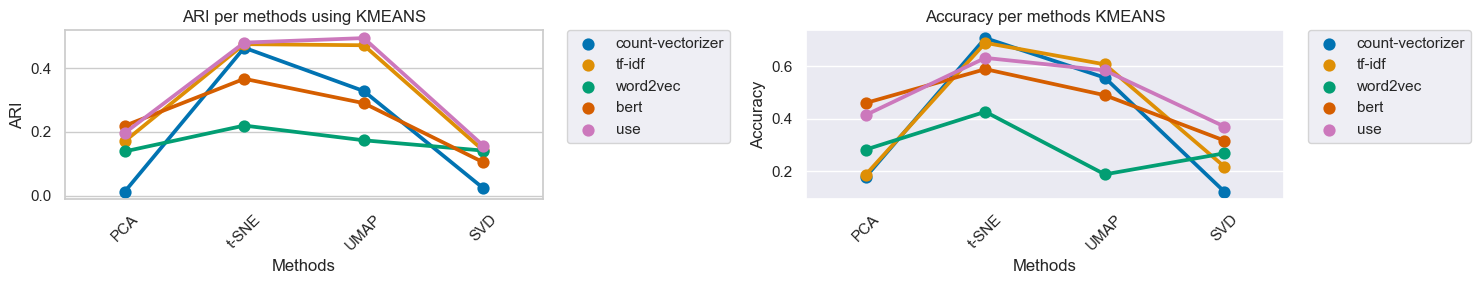

In [57]:
show_score_for_one_df(scs)

In [58]:
scores_by_df = [
    {"name": "all_with_lemm", "scores": calculate_accuracy_from_df(df_clean_lemm["clean_desc"])},
    {"name": "all_with_stemm", "scores": calculate_accuracy_from_df(df_clean_stemm["clean_desc"])},
    {"name": "raw", "scores": calculate_accuracy_from_df(df["description"])},
    {"name": "step1", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step1"])},
    {"name": "step2", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step2"])},
    {"name": "step3", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step3"])},
    {"name": "step4", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step4"])},
    {"name": "step5", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step5"])},
]

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [59]:
full_scores_dfs = pd.DataFrame({"dataframe":[], "feature_extraction":[], "reduction_method": [], "ari": [], "accuracy":[], "full_label":[] })
for _, df_item in enumerate(scores_by_df):
    for _, global_score in enumerate(df_item["scores"]):
        global_score["values"]["dataframe"] = df_item["name"]
        global_score["values"]["feature_extraction"] = global_score["name"]
        global_score["values"] = global_score["values"].rename(columns={'label': 'reduction_method'})
        global_score["values"]["full_label"] = global_score["values"].apply(lambda row: f'{df_item["name"]}-{global_score["name"]}-{row["reduction_method"]}', axis=1)  
        full_scores_dfs = pd.concat([full_scores_dfs, global_score["values"]], ignore_index=True)
        # for _, score in enumerate(global_score["values"]):
        #     # print(f'Label = {score["label"]}')
        #     # print(f'Label = {score["label"]}, accuracy = {score["accuracy"]}')
        #     print(global_score["values"].head())

In [60]:
full_scores_dfs

dataframe feature_extraction reduction_method       ari  accuracy  \
0    all_with_lemm  count-vectorizer   PCA              0.012154  0.179048   
1    all_with_lemm  count-vectorizer   t-SNE            0.464963  0.706667   
2    all_with_lemm  count-vectorizer   UMAP             0.285247  0.407619   
3    all_with_lemm  count-vectorizer   SVD              0.023008  0.122857   
4    all_with_lemm  tf-idf             PCA              0.170700  0.187619   
..             ...     ...             ...                   ...       ...   
155  step5          bert               SVD              0.080144  0.248571   
156  step5          use                PCA              0.286987  0.471429   
157  step5          use                t-SNE            0.418633  0.613333   
158  step5          use                UMAP             0.396978  0.378095   
159  step5          use                SVD              0.104011  0.248571   

                               full_label  
0    all_with_lemm-count-vectorizer-PCA    
1    all_with_lemm-count-vectorizer-t-SNE  
2    all_with_lemm-count-vectorizer-UMAP   
3    all_with_lemm-count-vectorizer-SVD    
4    all_with_lemm-tf-idf-PCA              
..                        ...              
155  step5-bert-SVD                        
156  step5-use-PCA                         
157  step5-use-t-SNE                       
158  step5-use-UMAP                        
159  step5-use-SVD                         

[160 rows x 6 columns]

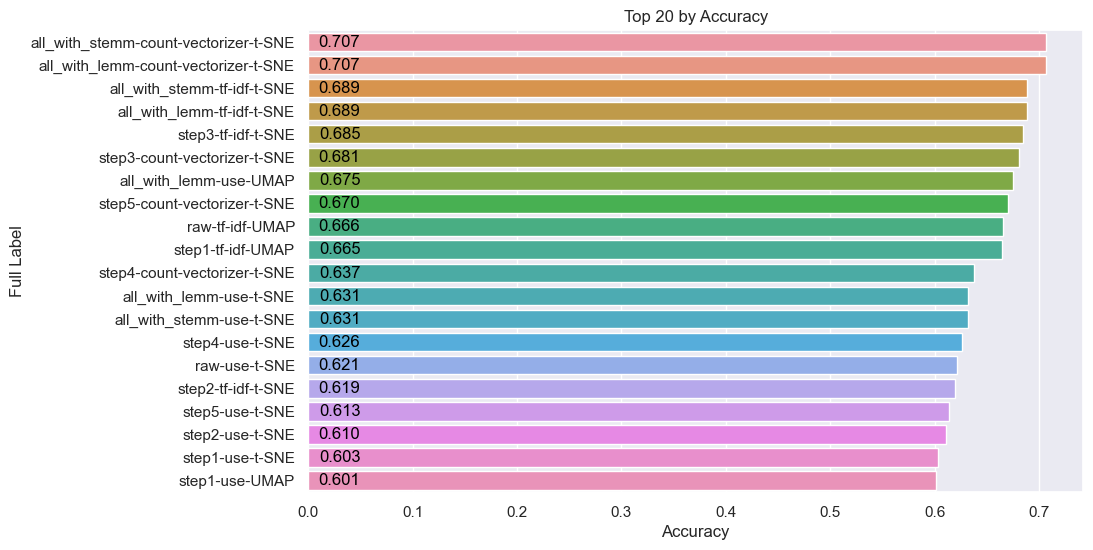

In [61]:
# Sort the dataframe by accuracy in descending order  
sorted_df = full_scores_dfs.sort_values(by='accuracy', ascending=False)  
  
# Select the top 20 records  
top_20_df = sorted_df.head(20).reset_index()
  
# Create the bar plot  
plt.figure(figsize=(10, 6))  
ax = sns.barplot(data=top_20_df, x='accuracy', y='full_label', orient='h')  
plt.xlabel('Accuracy')  
plt.ylabel('Full Label')  
plt.title('Top 20 by Accuracy')  

# Add accuracy scores within each bar  
for index, row in top_20_df.iterrows():  
    ax.text(0.05, index + 0.2, f"{row['accuracy']:.3f}", color='black', ha="right")  
  

plt.show()  

### Supervised Text

In [62]:
from sklearn.naive_bayes import MultinomialNB  
from sklearn.svm import SVC 

clusterings = [
    {"name": "RandomForestClassifier", "model": RandomForestClassifier()},
    # {"name": "Naive Bayes", "model": MultinomialNB(alpha=1.0)},  
    {"name": "Support Vector Machines", "model": SVC(kernel='linear', C=1.0)}  
]

dimension_reduction = [
    {"name": "None", "model": np.nan},
    {"name": "PCA", "model": PCA(n_components=2)},
    {"name": "t-SNE", "model": TSNE(n_components=2, perplexity=40, random_state=42)  },
    {"name": "UMAP", "model": UMAP(n_components=2) },
    {"name": "SVD", "model": TruncatedSVD(n_components=2) },
]


def check_one_df_supervised(dataFrame, draw_graph=False):
    
    df_scores = pd.DataFrame(columns=["label", "ari", "accuracy"])  

    for idx, dim_reduc in enumerate(dimension_reduction):
        for idx2, clustering in enumerate(clusterings):
            res = check_performance_supervised(dataFrame, 
                            dim_reduc["name"], 
                            dim_reduc["model"], 
                            clustering["name"], 
                            clustering["model"], 
                            df,
                            draw_graph)
            row = pd.DataFrame({"label": res["label"], "ari": res["ari_score"], "model": res["model"], "accuracy": res["accuracy"]}, index=[0])
            df_scores = pd.concat([df_scores, row], ignore_index=True)
            
    return df_scores

def check_performance_supervised(df, 
                      reduction_name,
                      reduction_method,
                      
                      supervised_name,
                      supervised_method,
                      
                      original_df,
                      draw_graph=False):
    
    print(reduction_name, supervised_method, df.shape)
    X = df
    y = original_df["cat_e"]

    if(reduction_name == "None"):
        X = X
    else:
        # Apply a dimensional reduction  
        X_reduced = reduction_method.fit_transform(df)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    supervised_method.fit(X_train, y_train)
    
    y_pred = supervised_method.predict(X_test)
    y_pred_full = supervised_method.predict(X)

    # Print the ARI score  
    ari_score = adjusted_rand_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # accuracy_adjusted = accuracy_score(y, clusters_adjusted)  
    
    if(draw_graph and reduction_name != "None"):
        print(f"ARI Score ({supervised_name} - {reduction_name}) : %.2f" % ari_score)  
        print(f"ACCURACY ({supervised_name} - {reduction_name}) : %.2f" % accuracy)  
        
        # Plot on the left the datapoints with existing categories  
        plt.figure(figsize=(12, 3))  
        plt.subplot(1, 2, 1)  
        sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=original_df['cat'], palette='Set1')  
        plt.title(f"Real Categories {supervised_name} - {reduction_name}")  
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  
        
        # Plot on the right the datapoints with determined categories
        plt.subplot(1, 2, 2)  
        sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_pred_full, palette='Set1')  
        plt.title(f"Predicted Categories {supervised_name} - {reduction_name}")  
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  
    
        plt.tight_layout()  
        plt.show()
    
    return {"label": f"{reduction_name}", "model": f"{supervised_name}", "ari_score": ari_score,"accuracy": accuracy, "clusters": y_pred_full}

Maintenant pour ma propre connaissance, je veux faire un test de précision sur plusieurs modèles ainsi que plusieurs hypothèses.
Je regroupe le tout dans un tableau qui sera mon benchmark leaderboard.

Un peu overkill mais très utile pour ma compréhension et futurs projets.

In [63]:
scores_by_df_supervised = [
    {"name": "all_with_lemm", "scores": calculate_accuracy_from_df(df_clean_lemm["clean_desc"], True)},
    {"name": "all_with_stemm", "scores": calculate_accuracy_from_df(df_clean_stemm["clean_desc"], True)},
    {"name": "raw", "scores": calculate_accuracy_from_df(df["description"], True)},
    {"name": "step1", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step1"], True)},
    {"name": "step2", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step2"], True)},
    {"name": "step3", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step3"], True)},
    {"name": "step4", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step4"], True)},
    {"name": "step5", "scores": calculate_accuracy_from_df(df_clean["clean_desc_step5"], True)},
]

None RandomForestClassifier() (1050, 2614)
None SVC(kernel='linear') (1050, 2614)
PCA RandomForestClassifier() (1050, 2614)
PCA SVC(kernel='linear') (1050, 2614)
t-SNE RandomForestClassifier() (1050, 2614)
t-SNE SVC(kernel='linear') (1050, 2614)
UMAP RandomForestClassifier() (1050, 2614)
UMAP SVC(kernel='linear') (1050, 2614)
SVD RandomForestClassifier() (1050, 2614)
SVD SVC(kernel='linear') (1050, 2614)
None RandomForestClassifier() (1050, 2614)
None SVC(kernel='linear') (1050, 2614)
PCA RandomForestClassifier() (1050, 2614)
PCA SVC(kernel='linear') (1050, 2614)
t-SNE RandomForestClassifier() (1050, 2614)
t-SNE SVC(kernel='linear') (1050, 2614)
UMAP RandomForestClassifier() (1050, 2614)
UMAP SVC(kernel='linear') (1050, 2614)
SVD RandomForestClassifier() (1050, 2614)
SVD SVC(kernel='linear') (1050, 2614)
None RandomForestClassifier() (1050, 2614)
None SVC(kernel='linear') (1050, 2614)
PCA RandomForestClassifier() (1050, 2614)
PCA SVC(kernel='linear') (1050, 2614)
t-SNE RandomForestClas

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



UMAP SVC(kernel='linear') (1050, 5940)


/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



SVD RandomForestClassifier() (1050, 5940)
SVD SVC(kernel='linear') (1050, 5940)
None RandomForestClassifier() (1050, 5940)
None SVC(kernel='linear') (1050, 5940)
PCA RandomForestClassifier() (1050, 5940)
PCA SVC(kernel='linear') (1050, 5940)
t-SNE RandomForestClassifier() (1050, 5940)
t-SNE SVC(kernel='linear') (1050, 5940)
UMAP RandomForestClassifier() (1050, 5940)
UMAP SVC(kernel='linear') (1050, 5940)
SVD RandomForestClassifier() (1050, 5940)
SVD SVC(kernel='linear') (1050, 5940)
None RandomForestClassifier() (1050, 4881)
None SVC(kernel='linear') (1050, 4881)
PCA RandomForestClassifier() (1050, 4881)
PCA SVC(kernel='linear') (1050, 4881)
t-SNE RandomForestClassifier() (1050, 4881)
t-SNE SVC(kernel='linear') (1050, 4881)
UMAP RandomForestClassifier() (1050, 4881)
UMAP SVC(kernel='linear') (1050, 4881)
SVD RandomForestClassifier() (1050, 4881)
SVD SVC(kernel='linear') (1050, 4881)
None RandomForestClassifier() (1050, 4881)
None SVC(kernel='linear') (1050, 4881)
PCA RandomForestClassi

In [64]:
full_scores_dfs_supervised = pd.DataFrame({"dataframe":[], "feature_extraction":[], "reduction_method": [], "ari": [], "accuracy":[], "full_label":[] })
for _, df_item in enumerate(scores_by_df_supervised):
    for _, global_score in enumerate(df_item["scores"]):
        global_score["values"]["dataframe"] = df_item["name"]
        global_score["values"]["feature_extraction"] = global_score["name"]
        global_score["values"] = global_score["values"].rename(columns={'label': 'reduction_method'})
        global_score["values"]["full_label"] = global_score["values"].apply(lambda row: f'{df_item["name"]}-{global_score["name"]}-{row["reduction_method"]}-{row["model"]}', axis=1)  
        full_scores_dfs_supervised = pd.concat([full_scores_dfs_supervised, global_score["values"]], ignore_index=True)
        # for _, score in enumerate(global_score["values"]):
        #     # print(f'Label = {score["label"]}')
        #     # print(f'Label = {score["label"]}, accuracy = {score["accuracy"]}')
        #     print(global_score["values"].head())

J'affiche le top 20 puis le bottom 20

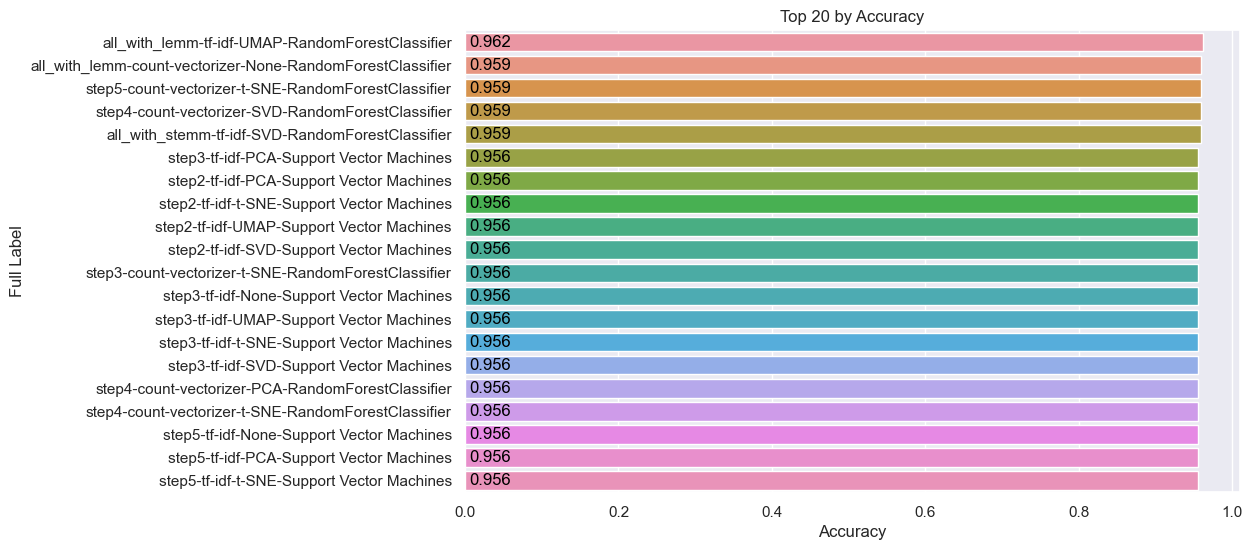

In [65]:
# Sort the dataframe by accuracy in descending order  
sorted_df_supervised = full_scores_dfs_supervised.sort_values(by='accuracy', ascending=False)  
  
# Select the top 20 records  
top_20_df_supervised = sorted_df_supervised.head(20).reset_index()
  
# Create the bar plot  
plt.figure(figsize=(10, 6))  
ax = sns.barplot(data=top_20_df_supervised, x='accuracy', y='full_label', orient='h')  
plt.xlabel('Accuracy')
plt.ylabel('Full Label')
plt.title('Top 20 by Accuracy')

# Add accuracy scores within each bar  
for index, row in top_20_df_supervised.iterrows():  
    ax.text(0.06, index + 0.2, f"{row['accuracy']:.3f}", color='black', ha="right")  
  

plt.show()  

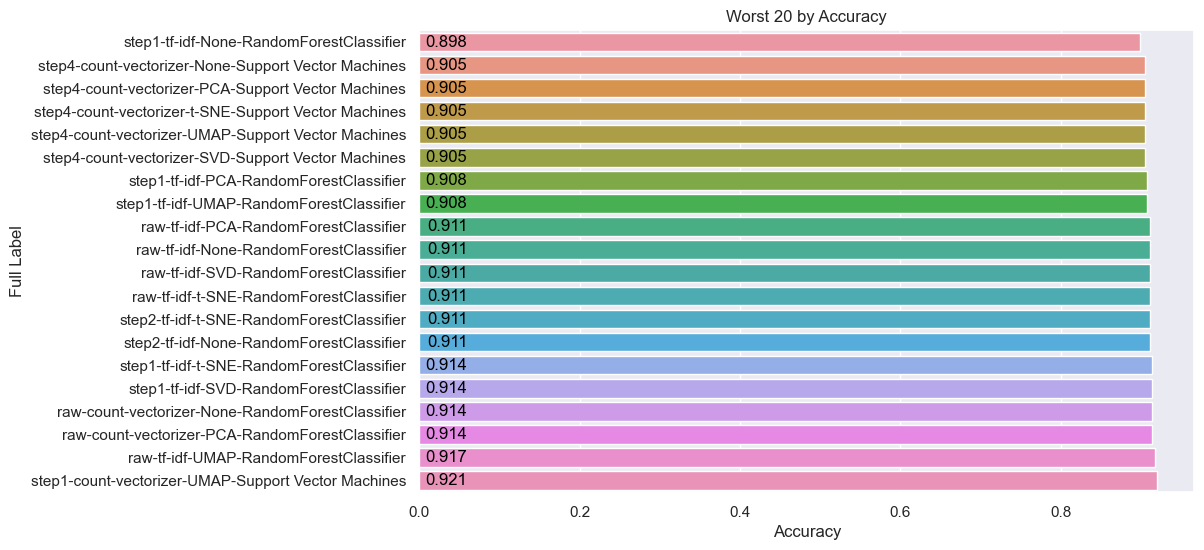

In [66]:
# Sort the dataframe by accuracy in descending order  
sorted_df_supervised = full_scores_dfs_supervised.sort_values(by='accuracy', ascending=True)  
  
# Select the top 20 records  
low_20_df_supervised = sorted_df_supervised.head(20).reset_index()
  
# Create the bar plot  
plt.figure(figsize=(10, 6))  
ax = sns.barplot(data=low_20_df_supervised, x='accuracy', y='full_label', orient='h')  
plt.xlabel('Accuracy')
plt.ylabel('Full Label')
plt.title('Worst 20 by Accuracy')

# Add accuracy scores within each bar  
for index, row in low_20_df_supervised.iterrows():  
    ax.text(0.06, index + 0.2, f"{row['accuracy']:.3f}", color='black', ha="right")  
  

plt.show()

J'observe les clusters sur le meilleur modèles

None RandomForestClassifier() (1050, 2614)
None SVC(kernel='linear') (1050, 2614)
PCA RandomForestClassifier() (1050, 2614)
ARI Score (RandomForestClassifier - PCA) : 0.89
ACCURACY (RandomForestClassifier - PCA) : 0.95


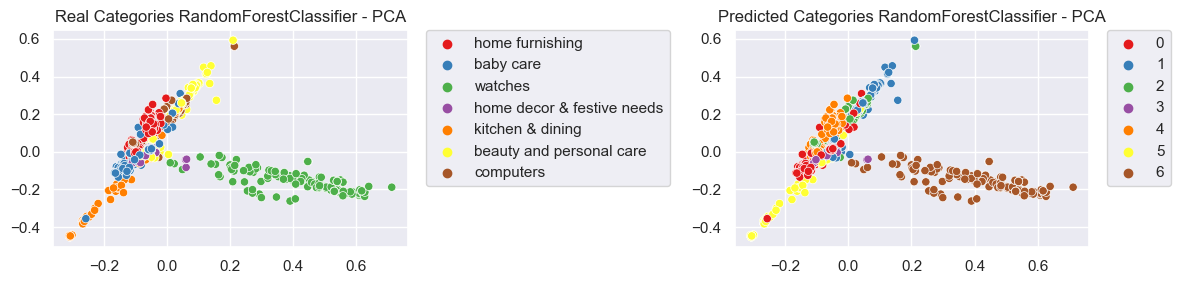

PCA SVC(kernel='linear') (1050, 2614)
ARI Score (Support Vector Machines - PCA) : 0.89
ACCURACY (Support Vector Machines - PCA) : 0.95


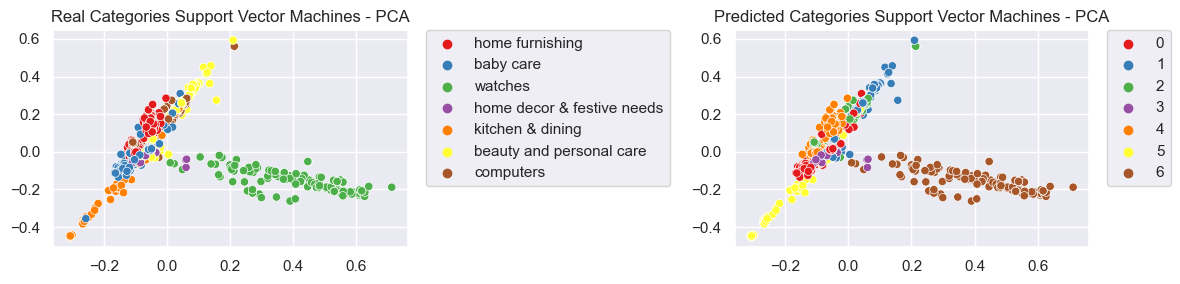

t-SNE RandomForestClassifier() (1050, 2614)
ARI Score (RandomForestClassifier - t-SNE) : 0.89
ACCURACY (RandomForestClassifier - t-SNE) : 0.95


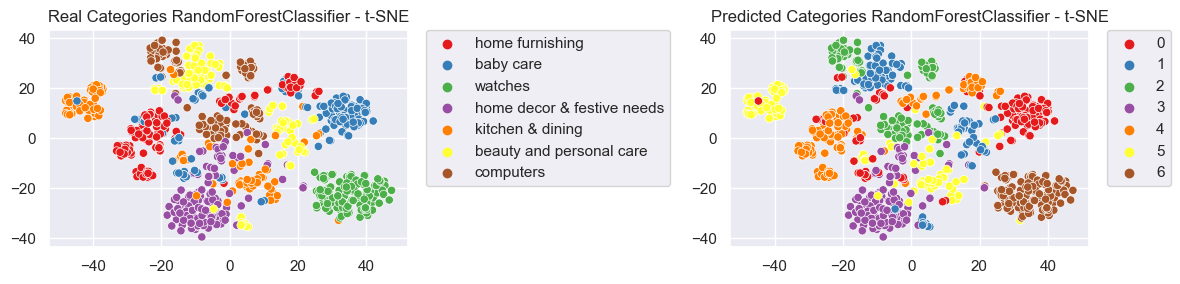

t-SNE SVC(kernel='linear') (1050, 2614)
ARI Score (Support Vector Machines - t-SNE) : 0.89
ACCURACY (Support Vector Machines - t-SNE) : 0.95


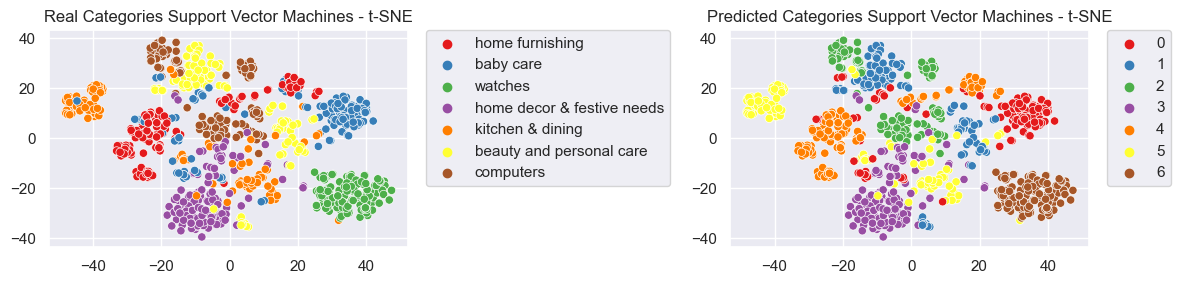

UMAP RandomForestClassifier() (1050, 2614)
ARI Score (RandomForestClassifier - UMAP) : 0.89
ACCURACY (RandomForestClassifier - UMAP) : 0.95


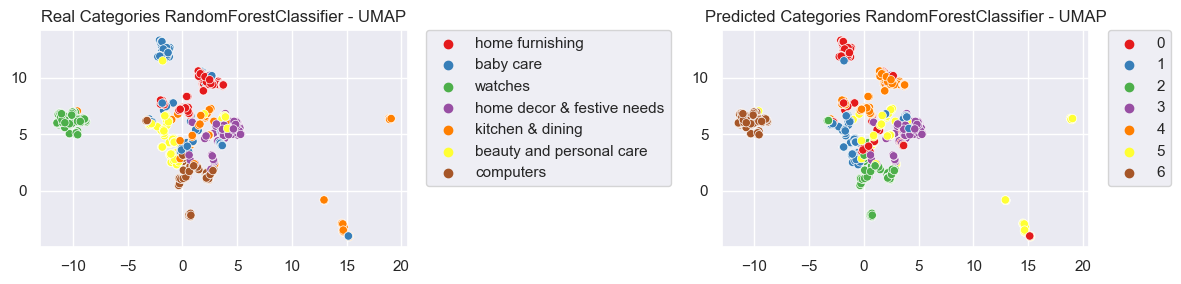

UMAP SVC(kernel='linear') (1050, 2614)
ARI Score (Support Vector Machines - UMAP) : 0.89
ACCURACY (Support Vector Machines - UMAP) : 0.95


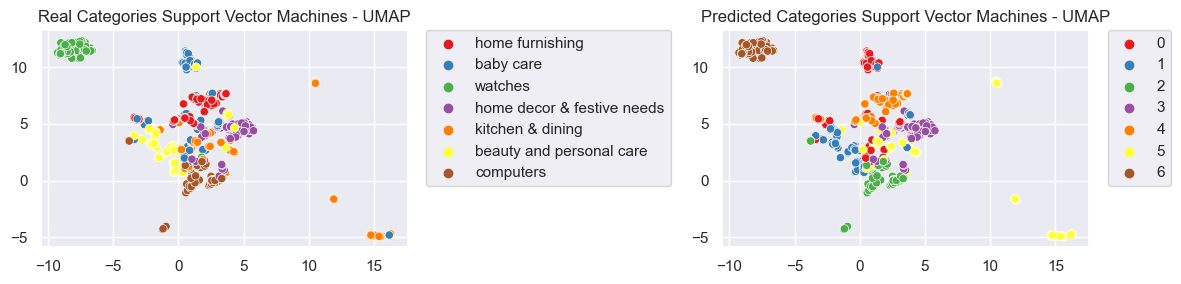

SVD RandomForestClassifier() (1050, 2614)
ARI Score (RandomForestClassifier - SVD) : 0.89
ACCURACY (RandomForestClassifier - SVD) : 0.95


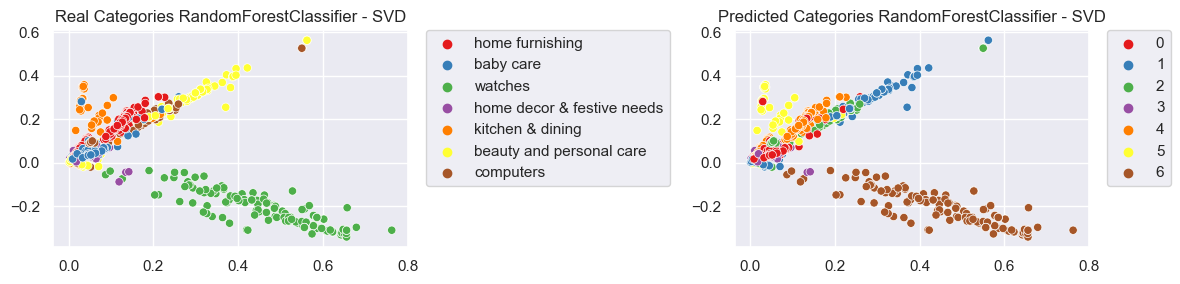

SVD SVC(kernel='linear') (1050, 2614)
ARI Score (Support Vector Machines - SVD) : 0.89
ACCURACY (Support Vector Machines - SVD) : 0.95


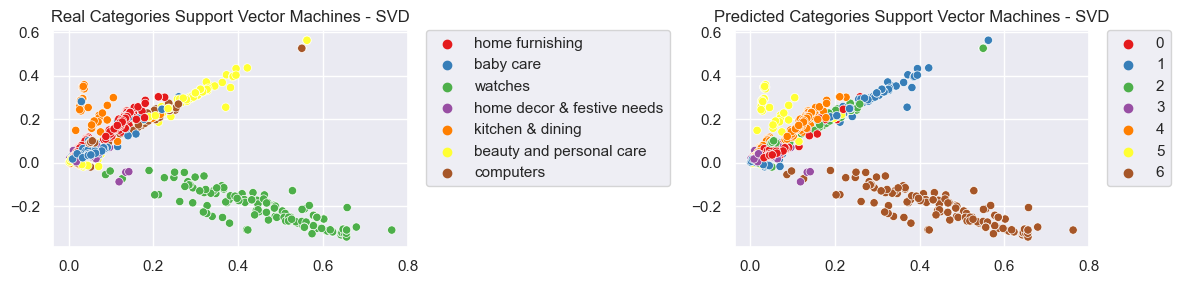

In [67]:
# Visualisation des clusters réels & prédits sur le meilleur dataframe
tfidf_vectorizer = TfidfVectorizer()  
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean_stemm['clean_desc'])  
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df_scores = check_one_df_supervised(tfidf_df, True)

Axes d'améliorations potentiels:
- Prédire les lvls 2/3/n
- Ajouter Bigrams/Trigrams

# IMAGES

## Observation des données

In [68]:
from sklearn import manifold, decomposition
import time
import cv2 #!pip install opencv-python opencv-contrib-python
from sklearn import cluster, metrics
from matplotlib.image import imread



In [69]:
images_folder_path = "./../input/tmp_flipkart_images/"

df["img_path"] = df.apply(lambda row: f'{images_folder_path}{row["uniq_id"]}.jpg', axis=1)  


In [70]:
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                                      product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain        
1  Sathiyas Cotton Bath Towel                                        
2  Eurospa Cotton Terry Face Towel Set                               
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4  Jaipur Print Cotton Floral King sized Double Bedsheet             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel                                                                       

J'affiche trois images par catégories

home furnishing


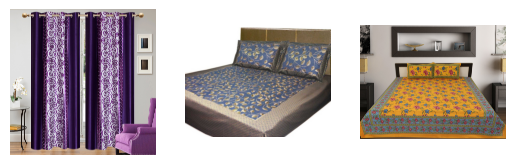

baby care


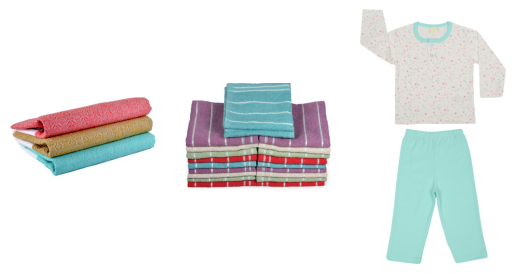

watches


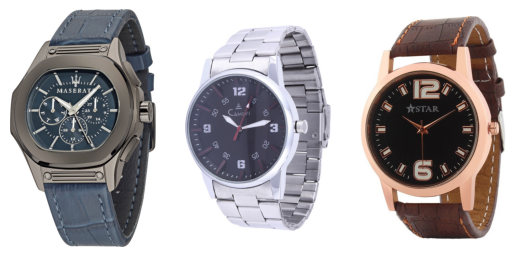

home decor & festive needs


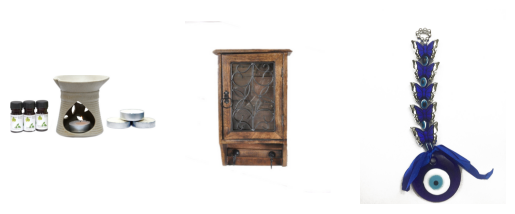

kitchen & dining


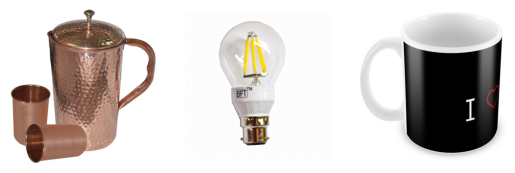

beauty and personal care


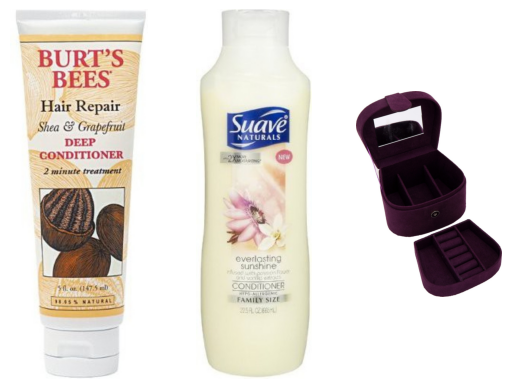

computers


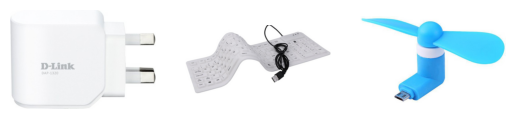

In [71]:

categories = df["cat"].unique()

for cat_name in categories :
    print(cat_name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        item = df[df["cat"] == cat_name].iloc[i]
        image = imread(item["img_path"])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

## Étude de faisabilité

### SIFT

SIFT est un algorithme qui détecte et décrit des points d'intérêt dans les images, c'est adapté à la reconnaissance d'objets.

#### Descripteurs

Je créer et affiche mes "descripteurs" / points d'intérêt sur une image

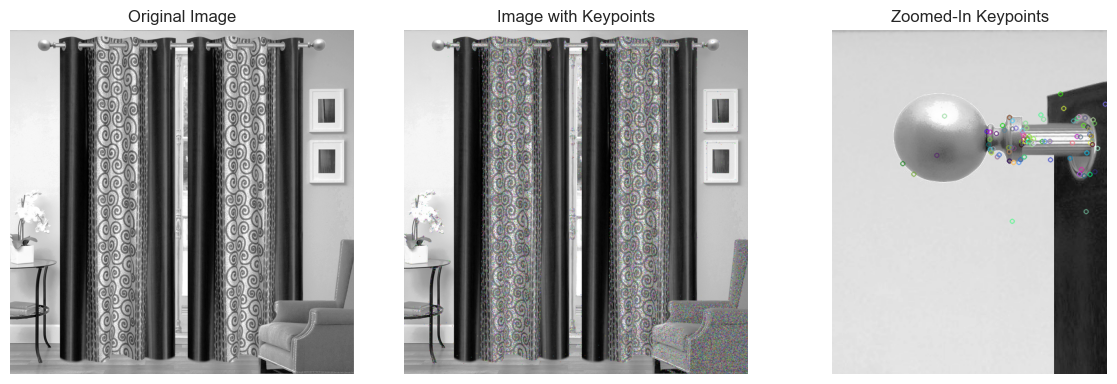

Descripteurs :  (98204, 128)

[[54. 35. 38. ... 21. 31. 22.]
 [58. 31. 24. ... 30. 28. 13.]
 [81. 51. 37. ... 42. 38. 14.]
 ...
 [34.  0.  0. ...  0.  0.  3.]
 [12.  5.  0. ...  0.  0.  1.]
 [27.  1.  0. ...  0.  0.  0.]]


In [72]:
def create_descriptor(img_path, nfeatures=0):
    
    # convert in gray
    image = cv2.imread(img_path, 0)
    
    # Enhance contrast using histogram equalization  
    image = cv2.equalizeHist(image)  
    
    # Create a SIFT object  
    sift = cv2.SIFT_create(nfeatures=nfeatures)  
    kp = sift.detect(image,None)
    image_with_keypoints=cv2.drawKeypoints(image,kp,image,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Detect and compute the keypoints and descriptors using SIFT  
    keypoints, descriptors = sift.detectAndCompute(image, None)
     # Sort the descriptors by their strength  
    descriptors = sorted(descriptors, key=lambda x: x.sum(), reverse=True)
    
    if nfeatures:
        # Truncate the descriptors to nfeatures because I sometimes get more
        descriptors = descriptors[:nfeatures]
    
    # Draw keypoints on the image  
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None) 
    return (image, image_with_keypoints, np.array(descriptors))

(original_image, img, descriptors) = create_descriptor(df.iloc[0]["img_path"])

# Create a figure with subplots  
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  
  
# Plot the original image  
axes[0].imshow(original_image, cmap='gray')  
axes[0].axis('off')  
axes[0].set_title('Original Image')  
  
# Plot the image with keypoints  
axes[1].imshow(img, cmap='gray')  
axes[1].axis('off')  
axes[1].set_title('Image with Keypoints')  
  
# Plot a zoomed-in portion of the image with keypoints  
zoomed_in = img[0:500, 200:600]  
axes[2].imshow(zoomed_in, cmap='gray')  
axes[2].axis('off')  
axes[2].set_title('Zoomed-In Keypoints')  
  
# Adjust the spacing between subplots  
fig.tight_layout()  
  
plt.show()  
  
print("Descripteurs : ", descriptors.shape)  
print()  
print(descriptors)  

#### Pré-traitement des images

##### Descripteurs pour chaque image

Je le fais pour chaque image

In [73]:
all_descriptors = []

for idx, img_path in enumerate(df["img_path"]):
    # if(idx < 341):
    #     continue
    # if(idx >= 30):
    #     break
    (_, _, descriptors) = create_descriptor(img_path)
    all_descriptors.append(descriptors)
    print(f"Progression {idx}/{len(df)} (shape: {descriptors.shape})", end="\r")
    

Je regarde combien j'ai de descriptors au minimum parmis tout mes descripteurs.
Je me base sur ce nombre pour recalculer tous mes descripteurs afin d'avoir la même taille et ne pas augmenter le poids d'une image sur l'algorithme

In [74]:
sorted_array = sorted(all_descriptors, key=lambda x: len(x))  
print("Top 3:")  
for subarray in sorted_array[-3:]:  
    print(len(subarray))
  
print("\nBottom 3:")  
for subarray in sorted_array[:3]:  
    print(len(subarray))  

Top 3:
189740
208464
433180

Bottom 3:
114
159
173


Je vais réduire le tout à 114

_SPOILER ALERT Note à moi même: Après avoir fini ce Notebook, je me rends compte qu'un axe d'amélioration pour SIFT serait de transformer l'image et la réduire en taille avant de créer le descripteurs. Sachant que SIFT n'est plus très utilisé je ne le modifierai pas ici mais je garde ça en tête. L'intérêt est très clair._

In [75]:
all_descriptors_adjusted = []

for idx, img_path in enumerate(df["img_path"]):
    # if(idx < 341):
    #     continue
    # if(idx >= 30):
    #     break
    (_, _, descriptors) = create_descriptor(img_path, 114)
    all_descriptors_adjusted.append(descriptors)
    print(f"Progression {idx}/{len(df)} (shape: {descriptors.shape})", end="\r")
    

In [76]:
descriptors_by_img = np.asarray(all_descriptors_adjusted)
descriptors_combined = np.concatenate(descriptors_by_img, axis=0)

print("Nombre de descripteurs : ", descriptors_combined.shape)

Nombre de descripteurs :  (119700, 128)


##### Clusters de descripteurs

In [77]:
k = int(round(np.sqrt(len(descriptors_combined)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(descriptors_combined)

Nombre de clusters estimés :  346
Création de 346 clusters de descripteurs ...


/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



MiniBatchKMeans(init_size=1038, n_clusters=346, random_state=0)

##### Extraction de features

La partie la plus importante, on créer des features, ici avec à un histogram des clusters.

In [78]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist



# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(descriptors_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

0
100
200
300
400
500
600
700
800
900
1000


#### Réduction de dimension étape 1 (PCA)

Je commence par réduire mes dimensions en utilisant d'abord PCA avec une variance expliqué de 99%.
C'est une première étape qui permet d'améliorer la vitesse de traitement considérablement pour une seconde étape qui réduira en 2 dimensions.  

_Fonctionne généralement mieux sur de très gros volumes_

In [79]:
print("Shape before", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Shape after", feat_pca.shape)

Shape before (1050, 346)
Shape after (1050, 296)


#### Réduction de dimension étape 2 (TSNE)

In [80]:
time1 = time.time()

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-time1
print("T-SNE time: ", "%15.2f" % duration1, "sec")


T-SNE time:             4.18 sec


#### Analyse visuelle

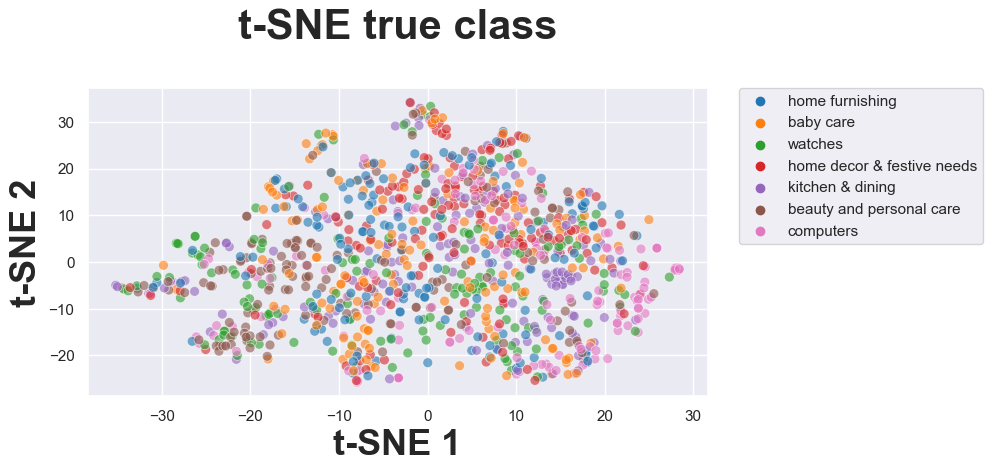

In [81]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["cat"]

plt.figure(figsize=(8,4))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('t-SNE true class', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('t-SNE 1', fontsize = 26, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 26, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

plt.show()

/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_3321/3412467513.py:7: UserWarning:


The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.



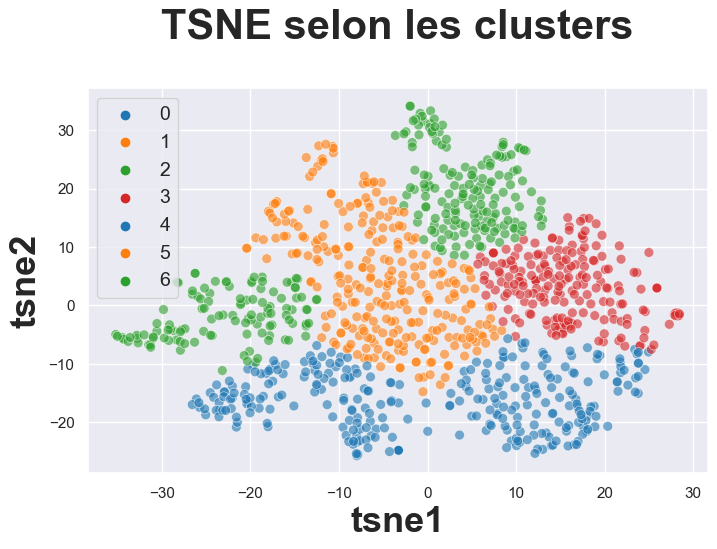

In [82]:
cls = KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
clusters_adjusted = modify_labels(df['cat_e'], df_tsne["cluster"])

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


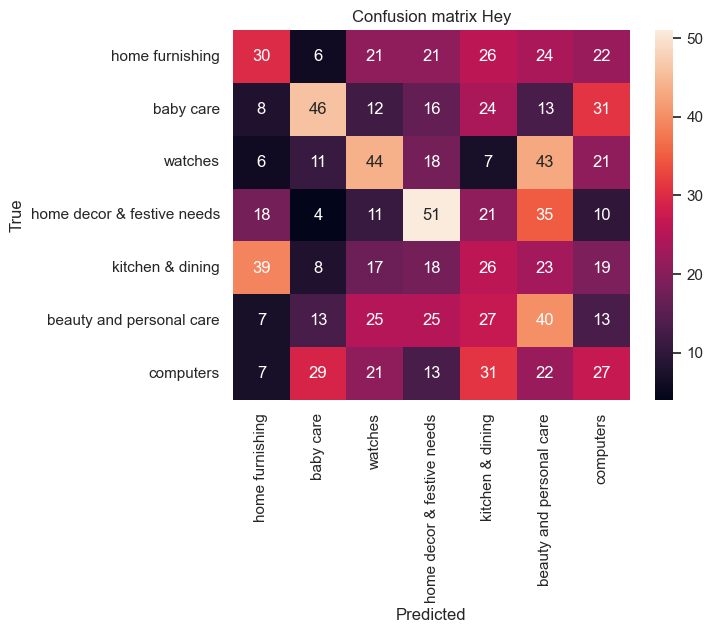

In [83]:
plot_confusion_matrix(df["cat_e"],clusters_adjusted, categories, "Hey")

#### Mesure de performance

In [84]:
print("ARI : ", adjusted_rand_score(df["cat"], clusters_adjusted))
print("Accuracy : ", accuracy_score(df["cat_e"], clusters_adjusted))

ARI :  0.035452143980026954
Accuracy :  0.25142857142857145


On obtiens pas un bon score. Beaucoup d'ax d'améliorations possible. SIFT étant peu utilisé, je souhaite m'attaquer à VGG16 et retournerai sur l'amélioration de SIFT si j'ai pas de bon résultat.

### CNN VGG16

Les CNNs (Convolutional Neural Network) sont des réseaux de neurones profonds optimisés pour les images. 
Ils apprennent à reconnaître des motifs comme les bords et les textures dans une image.

Je commence par créer mon modèle de base, et comme je fais du transfer learning pour utilisé ce qui a déjà été appris, j'indique l'input et outputs du dernier model. Je prends l'avant dernier output pour retravailler mon model au besoin.

In [85]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

#### Création des features des images

La partie la plus importante, on récupères les features des images pour pouvoir être analyser en utilisant model.predict

In [86]:
images_features = []
i=0 
for image_file in df["img_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input_vgg16(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



700
800
900
1000


(1050, 4096)

#### Réduction de dimension étape 1 (PCA)

Je commence par réduire mes dimensions en utilisant d'abord PCA avec une variance expliqué de 99%.
C'est une première étape qui permet d'améliorer la vitesse de traitement considérablement pour une seconde étape qui réduira en 2 dimensions.  

_Fonctionne généralement mieux sur de très gros volumes_

In [87]:
print("Shape before", images_features.shape)
pca = decomposition.PCA(n_components=0.99, random_state=42)
# feat_pca= pca.fit_transform(images_features)
print("Shape after", feat_pca.shape)


Shape before (1050, 4096)
Shape after (1050, 296)


#### Réduction de dimension étape 2 (TSNE)

In [88]:
time1 = time.time()

tsne = TSNE(n_components=2, perplexity=120, random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-time1
print("T-SNE time: ", "%15.2f" % duration1, "sec")


T-SNE time:             4.93 sec


#### Analyse visuelle

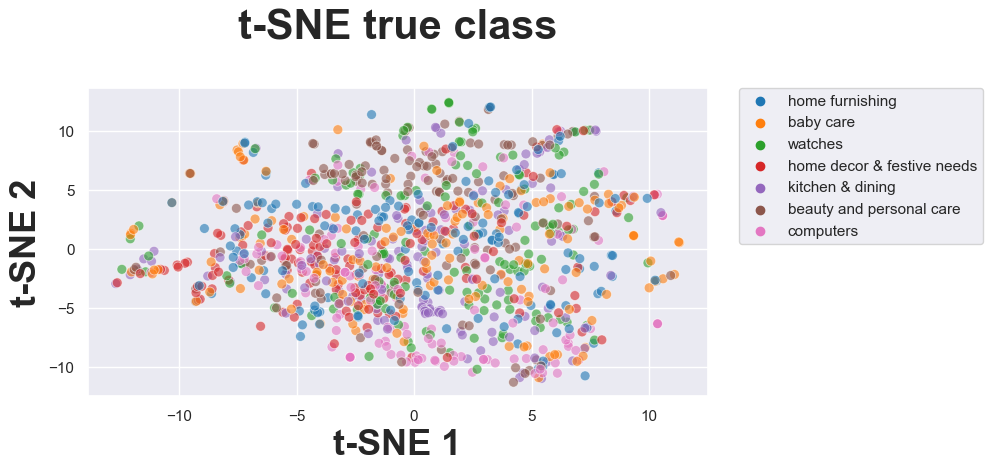

In [89]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["cat"]

plt.figure(figsize=(8,4))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('t-SNE true class', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('t-SNE 1', fontsize = 26, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 26, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

plt.show()

/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_3321/3339829661.py:7: UserWarning:


The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.



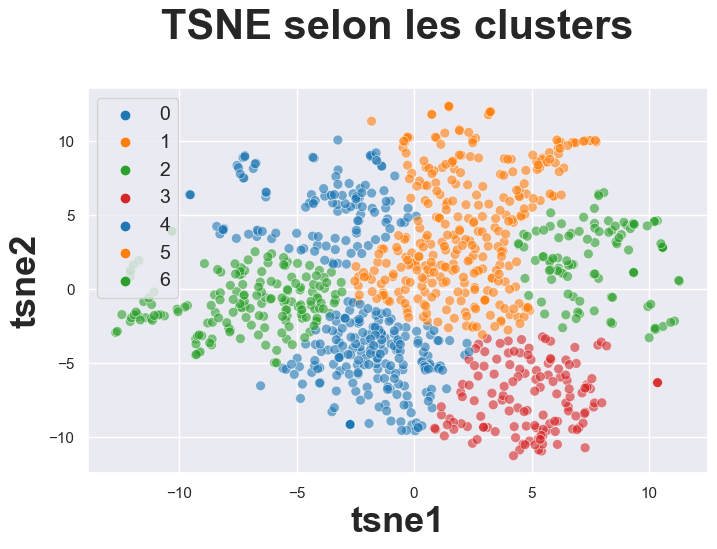

In [90]:
cls = KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
clusters_adjusted = modify_labels(df['cat_e'], df_tsne["cluster"])

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


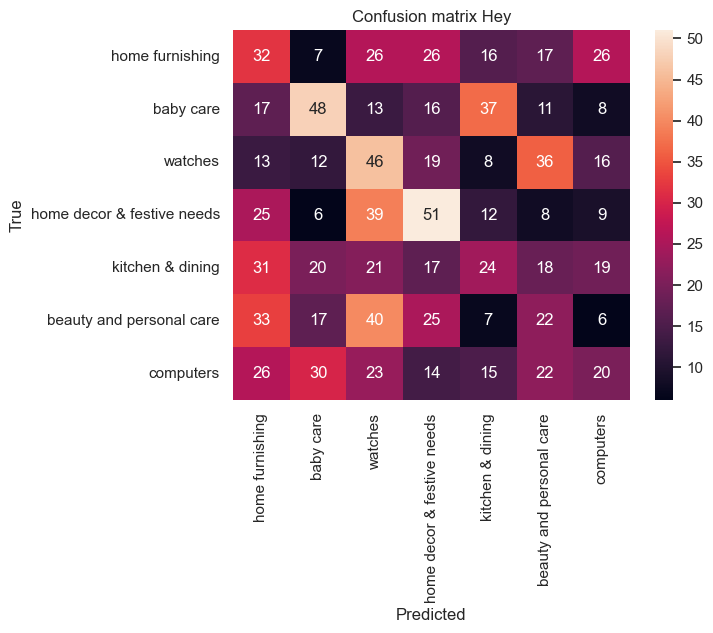

In [91]:
plot_confusion_matrix(df["cat_e"],clusters_adjusted, categories, "Hey")

#### Mesure de performance

In [92]:
print("ARI : ", adjusted_rand_score(df["cat"], clusters_adjusted))
print("Accuracy : ", accuracy_score(df["cat_e"], clusters_adjusted))

ARI :  0.03096095429180709
Accuracy :  0.23142857142857143


Bonne amélioration. Pour du non supervisé, je trouve que c'est prometteur.

## Text & image

Est-ce que les performances sont amélioré si on prend en compte les features extraites du text et de l'image en non supervisé pour en faire un dataframe ?

In [93]:
# Best feature extraction
df1 = tfidf_df.values

# Best images_features.shape
df2 = images_features

text_img_df = np.hstack((df1, df2)) 


In [94]:
text_img_df.shape

(1050, 6710)

Je normalise les données sinon les images prennent le dessus

In [95]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  
  
# Fit and transform the dataframe  
text_img_df_scaled = scaler.fit_transform(text_img_df)

In [96]:
tsne = TSNE(n_components=2, perplexity=120, random_state=42)
X_tsne = tsne.fit_transform(text_img_df)

cls = KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["cluster"] = cls.labels_

clusters_adjusted = modify_labels(df['cat_e'], df_tsne["cluster"])

print("ARI : ", adjusted_rand_score(df["cat"], clusters_adjusted))
print("Accuracy : ", accuracy_score(df["cat_e"], clusters_adjusted))


ARI :  0.4942234089575851
Accuracy :  0.7228571428571429


Pas forcément, le texte seul est mieux en non supervisé.  
On prouve ici que la faisabilité de classifier images et description est possible.

## Saved DF with image features

Je sauvegarde mon dataframe pour le réutiliser dans les autres notebooks

In [97]:
df.to_csv("./../input/df_cleaned_v2.csv", index=False)